# Setup

## Import modules

In [1]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, zscore

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, RobustScaler, MinMaxScaler, TargetEncoder, KBinsDiscretizer, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"


import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load data

In [2]:
# Load the dataset
auto = pd.read_csv("adverts.csv")

In [3]:
seed = 42

In [4]:
auto = auto.sample(500, random_state=seed)

# Identify erroneous data

### Price

In [5]:
# Drop rows with unrealistic prices
auto = auto.loc[auto["price"] != 9999999]

In [6]:
# Log scale price
auto["price"] = np.log(auto["price"])

### Mileage

In [7]:
# Very low mileage is likely erroneous for older used cars
auto.loc[
    (auto["mileage"] <= 100) & 
    (auto["vehicle_condition"] == "USED") & 
    (auto["year_of_registration"] < 2018), 
    "mileage"] = np.nan

### Year of reg

In [8]:
# Set the years of reg for new cars to 2020
auto.loc[(auto["vehicle_condition"]=="NEW") & (auto["year_of_registration"].isna()), "year_of_registration"] = 2020

In [9]:
# Remove very old years for non-old makes
# Note for me: "~"" means not
auto.loc[(auto["year_of_registration"] < 1950) & (~auto["standard_make"].isin(["Austin", "Morris"])), "year_of_registration"] = np.nan

# Custom Transformers

In [10]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_

        return input_features

### Reg code

In [11]:
class RegCodeToYear(CustomTransformer):
    '''
    Converts reg codes into years based on the letter or number.
    For letter codes there are two possible corresponding years,
    so both years are saved as a tuple.
    '''
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_ if hasattr(self, 'feature_names_in_') and self.feature_names_in_ is not None else []   
        return input_features

    def transform(self, X):
        X = X.copy()

        if not ("reg_code" in X):
            print("Skipping reg code to year as no reg code column is present.")
            return X

        def reg_to_year(reg_code):
            try:
                reg_code = int(reg_code)
                if reg_code > 71 or (50 > reg_code > 20): return np.nan
                return 2000 + reg_code % 50
            except (ValueError, TypeError):
                if not isinstance(reg_code, str): return np.nan
                letters = "ABCDEFGHJKLMNPRSTXY"
                if reg_code == "V": return (1979, 1999)
                if reg_code == "W": return (1980, 2000)
                if reg_code not in letters: return np.nan
                return (1983 + letters.find(reg_code), 1963 + letters.find(reg_code))

        # Apply the reg_to_year function and create the target column
        X["reg_code"] = X["reg_code"].map(reg_to_year)

        return X

In [12]:
class RegYearDisambiguator(CustomTransformer):
    '''
    Some letter reg codes can match to two different years e.g. "A" maps to both 1963 and 1983.
    This transformer finds the mean year of other cars of the same model and picks whichever of
    the two is closer to that mean. If there are no matching models of car the most recent year
    is taken as newer cars are more common in the dataset.
    '''   
    def transform(self, X):
        X = X.copy()
        
        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping reg year disambiguation as year is not present")
            return X
        
        def is_tuple(val):
            return isinstance(val, tuple)
            
        missing = X[(X["reg_code"].apply(is_tuple)) & (X["year_of_registration"].isna())]

        # For each ambiguous year select the year closest to the mean for that make.
        full_missing = X.loc[missing.index]

        for i in range(len(full_missing)):
            missing_model = full_missing.iloc[i]["standard_model"]
            years = full_missing.iloc[i]["reg_code"]
            used = X.loc[(X["standard_model"] == missing_model) & (X["year_of_registration"].notna())]

            mean_year = np.array(used["year_of_registration"]).mean()
            closest_year = years[0] if abs(mean_year - years[0]) < abs(mean_year - years[1]) else years[1]

            X.at[missing.index[i], "reg_code"] = closest_year

        return X

In [13]:
class FillYearWithReg(CustomTransformer):
    ''' Fill in missing year_of_registrations with the parsed data from the reg code.'''
    def get_feature_names_out(self, input_features=None):
        input_features = self.feature_names_in_

        return np.array([feature for feature in input_features if feature != "reg_code"])

    def transform(self, X):
        X = X.copy()

        if not("reg_code" in X or "year_of_registration" in X):
            print("Skipping fill year with reg as columns are not present.")
            return X

        to_fill = X.loc[X["year_of_registration"].isna()]
        # Copy the year from the reg code for missing years then drop reg code and reg code year
        X.loc[to_fill.index, "year_of_registration"] = X.loc[to_fill.index, "reg_code"]

        X.drop(columns=["reg_code"], inplace=True)
        
        return X

## Process data for model

In [14]:
class AutoEncodeBinary(CustomTransformer):
    ''' Find non numeric features with only two values and replace them with 0 and 1'''
    def transform(self, X):
        X = X.copy()

        for col in X:
            if isinstance(col, (str, bool))  and len(X[col].unique()) == 2:
                X[col] = X[col].replace({X[col].unique()[0]:0, X[col].unique()[1]:1})

        return X

In [15]:
class ParseReference(CustomTransformer):
    """ Extract date (in days) from public reference and then drop the column. """
    def get_feature_names_out(self, input_features=None):
        input_features = self.feature_names_in_

        return np.array(["reference" if feature == "public_reference" else feature for feature in input_features])

    def transform(self, X):
        X = X.copy()
        if not "public_reference" in X.columns:  # Check if column exists
            print("Skipping ParseReference as no public reference found in frame.")
            return X

        time = pd.DataFrame()
        time["year"] = X["public_reference"].astype(str).str[:4].astype(int)
        time["month"] = X["public_reference"].astype(str).str[4:6].astype(int)
        time["day"] = X["public_reference"].astype(str).str[6:8].astype(int)
        X["public_reference"] = round(time["year"] * 365.25 + time["month"] * 30.436875 + time["day"]).astype(int)
        X = X.rename({"public_reference": "reference"})

        return X

In [16]:
class MergeColours(CustomTransformer):
    """ Combines similar colours with few entries. """   
    def transform(self, X):
        X = X.copy()
        
        if not "standard_colour" in X:
            print("Skipping MergeColours as no standard_colour found in frame.")
            return X

        X = X.replace({
            "Navy": "Blue",
            "Magenta": "Pink", 
            "Burgundy": "Maroon", 
            "Indigo": "Purple"
            })

        return X

In [17]:
class RemoveMileageOutliers(CustomTransformer):
    """ Remove outliers beyond a certain z value for a mileage. """
    def __init__(self, z_threshold = 3):
        self.z_threshold = z_threshold

    def transform(self, X):
        X = X.copy()

        if self.z_threshold is None:
            return X
        
        miles = X.copy().loc[(X["mileage"].notna()) & X["year_of_registration"].notna()]
        miles["years_to_2020"] = 2021 - miles["year_of_registration"]
        miles["miles_per_year"] = round(miles["mileage"] / miles["years_to_2020"]).astype(np.int64)
        miles["z"] = np.abs(zscore(miles['miles_per_year']))

        X.loc[miles.loc[miles["z"] > self.z_threshold].index, "mileage"] = np.nan

        return X

In [18]:
class CombineMakeModel(CustomTransformer):
    '''Combine the makes and models into a single feature.'''
    def get_feature_names_out(self, input_features=None):       
        return np.array(["make_model" if feature == "standard_model" else feature for feature in self.feature_names_in_ if feature != "standard_make"])
    
    def transform(self, X):
        X = X.copy()
        
        # Combine make and model into one column
        X["standard_model"] = X["standard_make"] + " " + X["standard_model"]
        X = X.drop(columns=["standard_make"])
        X = X.rename({"standard_model": "make_model"})

        return X

In [19]:
class DropRegYear(CustomTransformer):
    def get_feature_names_out(self, input_features=None):       
        return np.array([feature for feature in self.feature_names_in_ if feature != "year_of_registration"])

    def transform(self, X):
        self.feature_names_in_ = X.columns  
        X = X.copy()
        X = X.drop(columns=["year_of_registration"])
        return X

In [20]:
class ImportanceImputer(CustomTransformer):
    '''
    Imputes categorical data by taking the mode of data which match other
    categorical features. The other categorical features are sorted based
    on their correlation with the target feature. To find the correlation
    Cramer's V is used. The imputer first attempts to locate entries that
    match every feature e.g. finding cars with the same make, model, year
    and condition. If no match is found, then the least important feature
    is ignored and the process continues until a minimum matching entries
    are found. Once found, the modes of the matches are filled in the gap.
    '''    
    def __init__(self, impute_features, similar_threshold=1):
        self.feature_names_in_ = []
        self.impute_features = impute_features
        self.similar_threshold = similar_threshold
        self.ordered_features = {}

    def fit(self, X, y=None):     
        self.feature_names_in_ = X.columns  
        X = X.copy()
        
        # Identify numeric and categorical features
        numerical_features = list(set(X.select_dtypes(include=[np.number]).columns))
        self.categorical_features_ = list(set(X.columns) - set(numerical_features))

        for feature in self.impute_features:
            # Compute Cramér"s V for categorical features
            self.cramer_dict_ = {}
            for feat in self.categorical_features_:
                if feat == feature: next
                
                contingency_table = pd.crosstab(X[feat], X[feature])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                r, k = contingency_table.shape
                cramer_v = np.sqrt((chi2 / n) / (min(r, k) - 1))
                self.cramer_dict_[feat] = cramer_v

            self.cramer_dict_ = dict(sorted(self.cramer_dict_.items(), key=lambda x: -x[1]))

            ordered_features = list(self.cramer_dict_.keys())
            if feature in ordered_features: ordered_features.remove(feature)
            self.ordered_features[feature] = ordered_features

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.impute_features:
            # Impute missing values
            missing_indices = X[X[feature].isna()].index

            def impute_value(row):
                features_to_match = self.ordered_features[feature].copy()
                while features_to_match:
                    condition = True
                    for feat in features_to_match:
                        condition &= X[feat] == row[feat]
                    similar_entries = X.loc[condition & X[feature].notna()]
                    if len(similar_entries) >= self.similar_threshold:
                        return similar_entries[feature].mode()[0]
                    features_to_match.pop()

                return X[feature].mode()[0]

            # Apply imputation
            X.loc[missing_indices, feature] = X.loc[missing_indices].apply(impute_value, axis=1)

        return X

In [21]:
class AddAnnualMileage(CustomTransformer):
    def get_feature_names_out(self, input_features=None):       
        return np.append(self.feature_names_in_, "annual_mileage")

    def transform(self, X):
        self.feature_names_in_ = X.columns
        X = X.copy()
        X["annual_mileage"] = X["mileage"]/(2021 - X["year_of_registration"])
        return X

# Setup Pipelines

In [22]:
cat_features = ["year_of_registration", "standard_colour", "standard_make", "standard_model", "vehicle_condition", "body_type", "crossover_car_and_van", "fuel_type"]
num_features = ["reference", "mileage", "year_of_registration"]

general_process = Pipeline([
    ("r2y", RegCodeToYear()),
    ("ryd", RegYearDisambiguator()),
    ("fyr", FillYearWithReg()),
    ("aeb", AutoEncodeBinary()),
    ("par", ParseReference()),
    ("col", MergeColours()),
    # ("mpy", AddAnnualMileage()),
    # ("out", RemoveMileageOutliers(z_threshold=3)),
])
cat_pipe = Pipeline([
    ("imp", ImportanceImputer(impute_features=cat_features)),
    # ("imp", SimpleImputer(strategy="most_frequent")),
    ("cmm", CombineMakeModel()),
    ("drg", DropRegYear()),
    ("ohenc", OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int))
])
num_pipe = Pipeline([
    ("imp", KNNImputer()),
    ("scl", RobustScaler()),
    ("tsf", PowerTransformer()),
    ("scl2", MinMaxScaler()),
    # ("bin", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
])
col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ])
preprocessor = Pipeline([
    ("gen", general_process),
    ("pre", col_transformer)
]).set_output(transform="pandas")

In [23]:
knn_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("knn", KNeighborsRegressor())
])

dtr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("dtr", DecisionTreeRegressor())
])

lnr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("lnr", LinearRegression())
])

set_config(display="diagram")
knn_pipeline

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('gen',
                                  Pipeline(steps=[('r2y', RegCodeToYear()),
                                                  ('ryd',
                                                   RegYearDisambiguator()),
                                                  ('fyr', FillYearWithReg()),
                                                  ('aeb', AutoEncodeBinary()),
                                                  ('par', ParseReference()),
                                                  ('col', MergeColours())])),
                                 ('pre',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imp',
                                                                                    KNNImputer()),
                                                                                   ('scl',
                                                                                    RobustScaler()),
                                                                                   ('tsf',
                                                                                    PowerTran...
                                                                                                                       'crossover_car_and_van',
                                                                                                                       'fuel_type'])),
                                                                                   ('cmm',
                                                                                    CombineMakeModel()),
                                                                                   ('drg',
                                                                                    DropRegYear()),
                                                                                   ('ohenc',
                                                                                    OneHotEncoder(dtype=<class 'int'>,
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['year_of_registration',
                                                                    'standard_colour',
                                                                    'standard_make',
                                                                    'standard_model',
                                                                    'vehicle_condition',
                                                                    'body_type',
                                                                    'crossover_car_and_van',
                                                                    'fuel_type'])]))])),
                ('knn', KNeighborsRegressor())])

# Train test split

In [24]:
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Cross validate models

In [25]:
knn_pipeline.set_params(knn__n_neighbors=5)
scores = cross_val_score(knn_pipeline, X, y, cv=5, n_jobs=12)

print(f"Mean Score: {round(scores.mean(), 3)}\nScore STD: {round(scores.std(),3)}\nAll Scores: {scores}")

Mean Score: 0.512
Score STD: 0.049
All Scores: [0.51073635 0.48568147 0.55731548 0.43510598 0.57070939]


<p style="font-family:monospace">
<pre>
<span style="font-size:0.9em;">
    Mean Score: 0.853
    Score STD: 0.002
    All Scores: [0.85268541 0.85258516 0.85600912 0.85143071 0.85352867]
</span>
</pre>
</p>

In [26]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
scores = cross_val_score(dtr_pipeline, X, y, n_jobs=12)

print(f"Mean Score: {round(scores.mean(), 3)}\nScore STD: {round(scores.std(),3)}\nAll Scores: {scores}")

Mean Score: 0.547
Score STD: 0.042
All Scores: [0.54926838 0.59741329 0.47209515 0.54468517 0.57054704]


<p style="font-family:monospace">
<pre>
<span style="font-size:0.9em;">
    Mean Score: 0.886
    Score STD: 0.003
    All Scores: [0.8821905  0.88329841 0.88773236 0.8886342  0.88670286]
</span>
</pre>
</p>

In [27]:
scores = cross_val_score(lnr_pipeline, X, y, n_jobs=12)

print(f"Mean Score: {round(scores.mean(), 3)}\nScore STD: {round(scores.std(),3)}\nAll Scores: {scores}")

Mean Score: 0.708
Score STD: 0.011
All Scores: [0.71256099 0.71086955 0.72014033 0.68831319 0.70891004]


<p style="font-family:monospace">
<pre>
<span style="font-size:0.9em;">
    Mean Score: 0.897
    Score STD: 0.002
    All Scores: [0.89844907 0.8948629  0.89437632 0.89959797 0.89575401]
</span>
</pre>
</p>

# Running Models

In [28]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
knn_pipeline.set_params(knn__n_neighbors=5)

models=[];
models.append(('LNR', lnr_pipeline))
models.append(("KNN", knn_pipeline))
models.append(('DTR', dtr_pipeline))

# Set a seed for reproducibility
np.random.seed(seed)

names=[];
result=[];
for name,model in models:
    k_fold=KFold(n_splits=5, shuffle=True, random_state=seed)
    score=cross_val_score(model, X, y, n_jobs=12, cv=k_fold);
    result.append(score)
    names.append(name)
    print(name, score.mean().round(3), score.std().round(3))

LNR 0.707 0.033
KNN 0.498 0.068
DTR 0.538 0.105


<p style="font-family:monospace">
<pre>
<span style="font-size:0.9em;">
LNR 
    - mean score: 0.897
    - standard deviation:  0.211
</br>
KNN 
    - mean score: 0.853
    - score std:  0.0.003
</br>
DTR 
    - mean score: 0.886
    - score std:  0.002
</span>
</pre>
</p>

In [29]:
result

[array([0.69701686, 0.70006517, 0.66974169, 0.69987553, 0.76979944]),
 array([0.400451  , 0.51890464, 0.53935523, 0.58834393, 0.44333783]),
 array([0.399348  , 0.48560238, 0.63670489, 0.48640423, 0.68029948])]

[Text(0, 0.5, 'Model'), Text(0.5, 0, 'Model Score')]

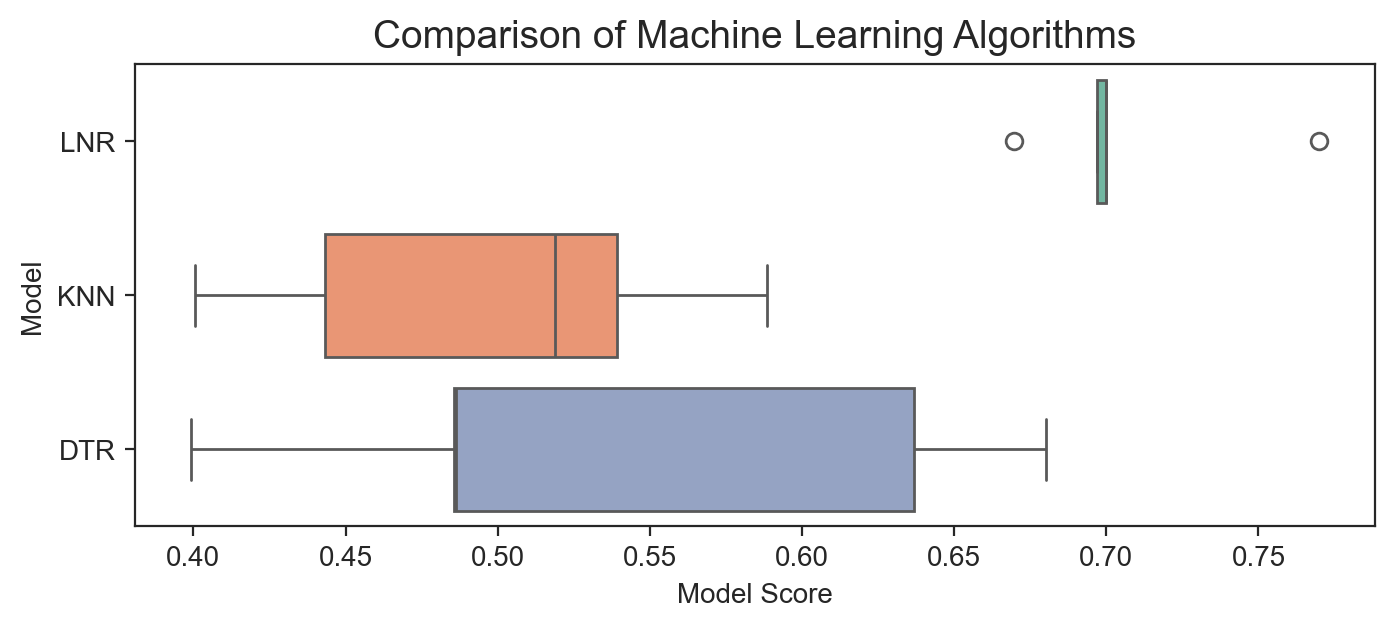

In [30]:
plt.figure(figsize=(8, 3))
sns.boxplot(result, orient="h")
plt.yticks([0, 1, 2], names)
# plt.xlim(0, 1)
plt.title('Comparison of Machine Learning Algorithms',fontsize=14)
plt.gca().set(ylabel='Model', xlabel='Model Score')
# plt.savefig("/Users/hal/Documents/Essays/AutoML/algorithm_box_plot4.png", bbox_inches='tight', dpi=240)

# Parameter Evaluation/Grid Search

## Misc Grid Search

### Importance Imputer

In [31]:
param_grid = {
    'preprocess__pre__cat__imp__similar_threshold': np.arange(1, 20, 2)
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(lnr_pipeline, param_grid, cv=3, n_jobs=6, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [32]:
print("Best one-hot params:", gs_results.best_params_)
gs_df.sort_values('rank_test_score').head()

Best one-hot params: {'preprocess__pre__cat__imp__similar_threshold': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess__pre__cat__imp__similar_threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.290324,0.019290,0.052425,0.002094,1,{'preprocess__pre__cat__imp__similar_threshold...,0.666637,0.644858,0.716343,0.675946,0.029917,1,0.946031,0.951782,0.963024,0.953612,0.007057
1,0.302668,0.016688,0.054234,0.009375,3,{'preprocess__pre__cat__imp__similar_threshold...,0.666637,0.644858,0.716343,0.675946,0.029917,1,0.946031,0.951782,0.963024,0.953612,0.007057
2,0.574988,0.025948,0.083400,0.003646,5,{'preprocess__pre__cat__imp__similar_threshold...,0.666294,0.644366,0.716639,0.675766,0.030256,3,0.946039,0.951682,0.963024,0.953582,0.007063
3,0.596971,0.010049,0.083509,0.003053,7,{'preprocess__pre__cat__imp__similar_threshold...,0.666294,0.644366,0.716639,0.675766,0.030256,3,0.946039,0.951682,0.963024,0.953582,0.007063
4,0.460639,0.005614,0.070720,0.002071,9,{'preprocess__pre__cat__imp__similar_threshold...,0.666294,0.644366,0.716639,0.675766,0.030256,3,0.946039,0.951682,0.963024,0.953582,0.007063


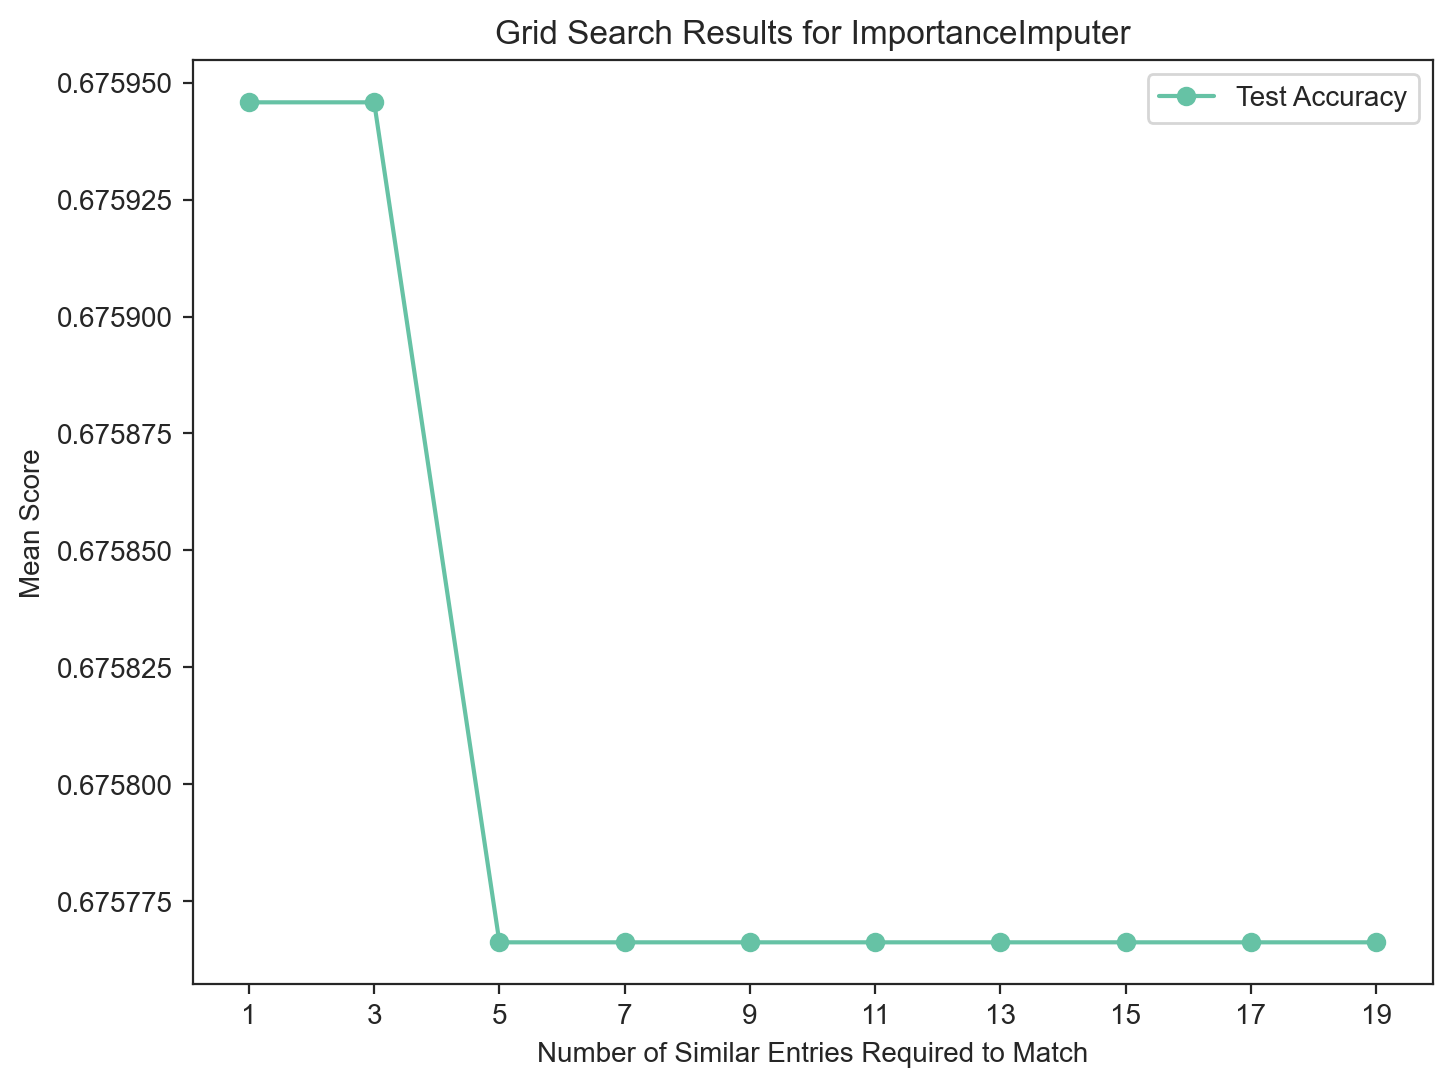

In [33]:
param_values = gs_df['param_preprocess__pre__cat__imp__similar_threshold'].astype(int)  # Convert to integer if not already
mean_train_scores = gs_df['mean_train_score'].astype(float)
mean_test_scores = gs_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot both training and test accuracy values
# plt.plot(param_values, mean_train_scores, label='Training Accuracy', marker='o')
plt.plot(param_values, mean_test_scores, label='Test Accuracy', marker='o')

# Label the x-axis and y-axis
plt.xlabel('Number of Similar Entries Required to Match')
plt.ylabel('Mean Score')

# Set x-axis ticks to the 'n_neighbors' values
plt.xticks(param_values)

# Show plot title and display the plot
plt.title('Grid Search Results for ImportanceImputer')
plt.legend()
plt.savefig("/Users/hal/Documents/Essays/AutoML/importance_grid_search.png", bbox_inches='tight', dpi=240)

### OneHotEncoder

In [34]:
param_grid = {
    'preprocess__pre__cat__ohenc__min_frequency': [1, 2, 5, 10, 30, 50],
    'preprocess__pre__cat__ohenc__max_categories': [10, 100, 200, 300, 400, 500, None],
    'preprocess__pre__cat__ohenc__drop': [None, "first", "if_binary"],
    'preprocess__pre__cat__ohenc__handle_unknown': ['ignore', 'infrequent_if_exist'],
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(lnr_pipeline, param_grid, cv=3, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [35]:
print("Best one-hot params:", gs_results.best_params_)
gs_df.sort_values('rank_test_score').head()

# Best one-hot params: {
#       'preprocess__pre__cat__ohenc__drop': None,
#       'preprocess__pre__cat__ohenc__handle_unknown': 'ignore', 
#       'preprocess__pre__cat__ohenc__max_categories': None, 
#       'preprocess__pre__cat__ohenc__min_frequency': 1}

Best one-hot params: {'preprocess__pre__cat__ohenc__drop': 'if_binary', 'preprocess__pre__cat__ohenc__handle_unknown': 'ignore', 'preprocess__pre__cat__ohenc__max_categories': 100, 'preprocess__pre__cat__ohenc__min_frequency': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess__pre__cat__ohenc__drop,param_preprocess__pre__cat__ohenc__handle_unknown,param_preprocess__pre__cat__ohenc__max_categories,param_preprocess__pre__cat__ohenc__min_frequency,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
174,0.852702,0.031318,0.217789,0.028624,if_binary,ignore,100,1,{'preprocess__pre__cat__ohenc__drop': 'if_bina...,0.628128,0.676994,0.729997,0.678373,0.041599,1,0.875617,0.869607,0.869024,0.871416,0.002980
6,0.918692,0.059646,0.182608,0.009397,None,ignore,100,1,"{'preprocess__pre__cat__ohenc__drop': None, 'p...",0.627745,0.676994,0.729997,0.678245,0.041754,2,0.875617,0.869607,0.869024,0.871416,0.002980
180,0.787228,0.030437,0.125199,0.014092,if_binary,ignore,200,1,{'preprocess__pre__cat__ohenc__drop': 'if_bina...,0.666447,0.644683,0.717131,0.676087,0.030352,3,0.946031,0.951782,0.963024,0.953612,0.007057
228,0.623437,0.006740,0.108651,0.006656,if_binary,infrequent_if_exist,300,1,{'preprocess__pre__cat__ohenc__drop': 'if_bina...,0.666447,0.644683,0.717131,0.676087,0.030352,3,0.946031,0.951782,0.963024,0.953612,0.007057
222,0.860815,0.025064,0.134516,0.010778,if_binary,infrequent_if_exist,200,1,{'preprocess__pre__cat__ohenc__drop': 'if_bina...,0.666447,0.644683,0.717131,0.676087,0.030352,3,0.946031,0.951782,0.963024,0.953612,0.007057


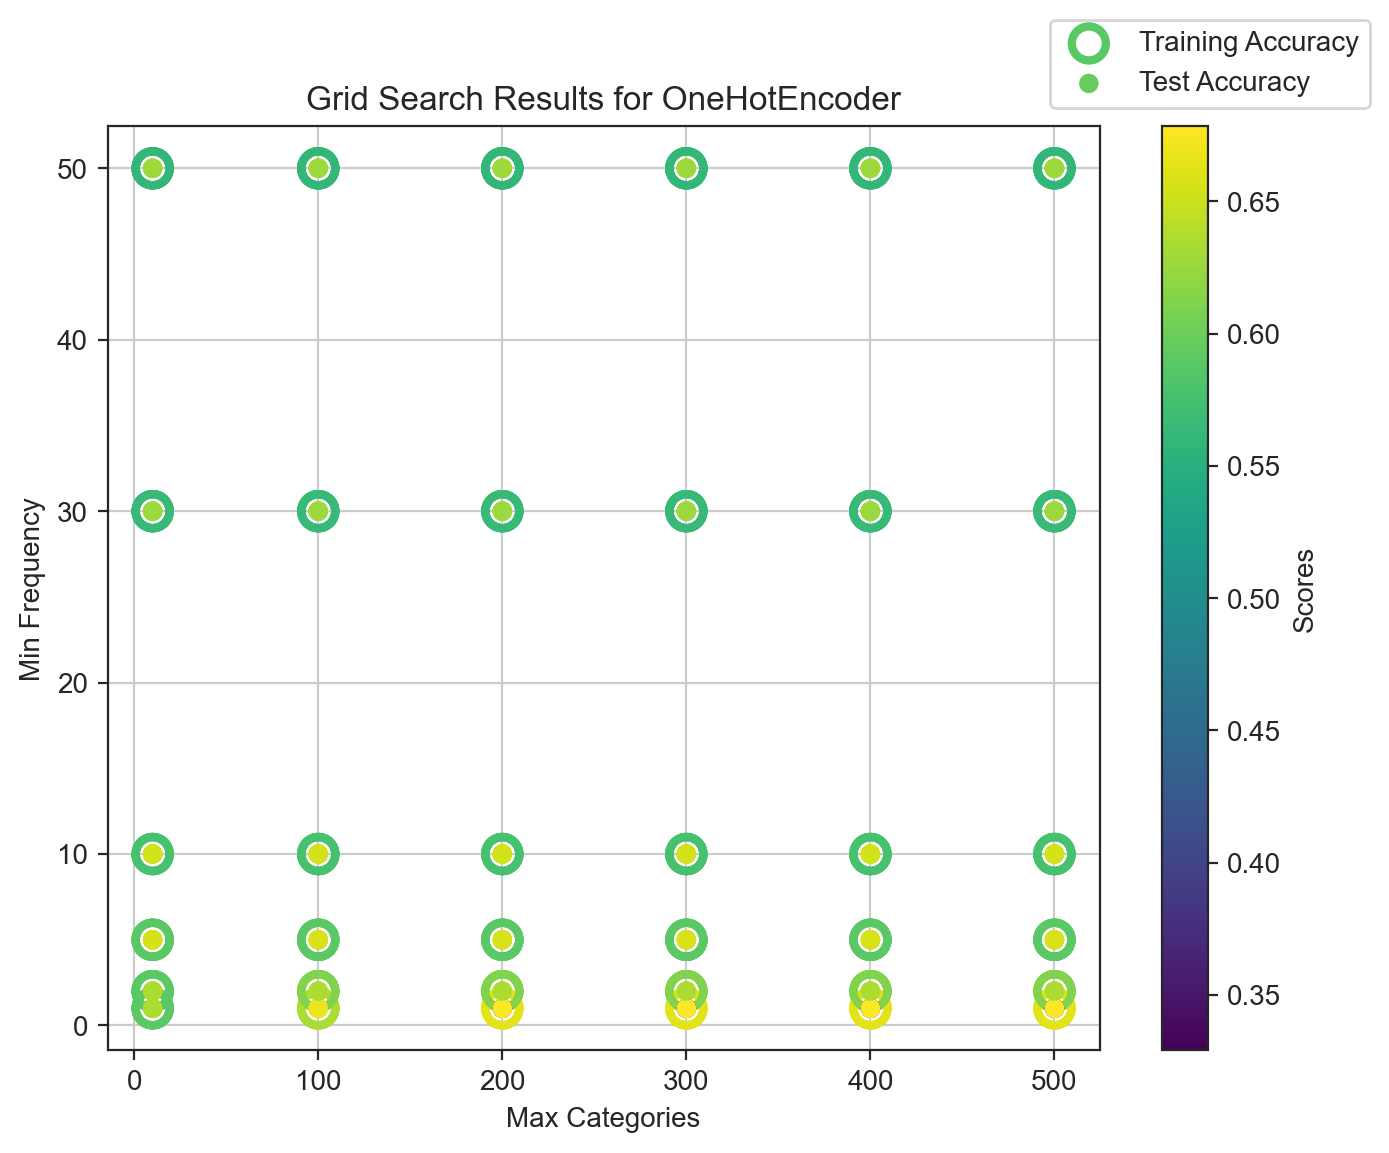

In [36]:
new_df = gs_df.dropna()
param_vals_1 = new_df['param_preprocess__pre__cat__ohenc__max_categories']
# param_vals_1 = param_vals_1.replace({None: 0})
param_vals_2 = new_df['param_preprocess__pre__cat__ohenc__min_frequency']
# param_vals_2 = param_vals_2.replace({None: 0})

mean_train_scores = new_df['mean_train_score'].astype(float)
mean_test_scores = new_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

plt.scatter(
    param_vals_1, 
    param_vals_2, 
    edgecolors=plt.cm.viridis(mean_train_scores),  # Color for edges
    facecolors='none',  # No fill
    s=150,  # Marker size
    linewidths=3,
    label='Training Accuracy'
)

scatter2 = plt.scatter(param_vals_1, param_vals_2, c=mean_test_scores, cmap='viridis', marker="o", label='Test Accuracy')

# Label the x-axis and y-axis
plt.ylabel('Min Frequency')
plt.xlabel('Max Categories')

# Show plot title and display the plot
plt.title('Grid Search Results for OneHotEncoder')
plt.legend(loc=(0.95, 1.02))
# plt.xticks(param_vals_1.unique())#, [50, 100, 200, 300, 400])
# plt.yticks(param_vals_2.unique())#, [1, 2, 5, 10, 30, 50, 100])
plt.grid(True)
cbar = plt.colorbar(scatter2, cmap="viridis")
cbar.set_label('Scores')
# plt.savefig("/Users/hal/Documents/Essays/AutoML/dtr_grid_search4.png", bbox_inches='tight', dpi=240)

## KNN Grid Search

In [37]:
# Define the parameter grid for 'n_neighbors' from 1 to 20
param_grid = {
    'knn__n_neighbors': list(range(1, 15))
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(knn_pipeline, param_grid, cv=3, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [38]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_knn__n_neighbors', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head()

,param_knn__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
3,4,0.709136,0.003212,0.507806,0.019830,1
2,3,0.735525,0.008256,0.498104,0.054856,2
5,6,0.674744,0.009075,0.495192,0.017544,3
7,8,0.625136,0.003932,0.495072,0.036216,4
4,5,0.693700,0.008246,0.493587,0.023172,5


In [39]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

{'knn__n_neighbors': 4}

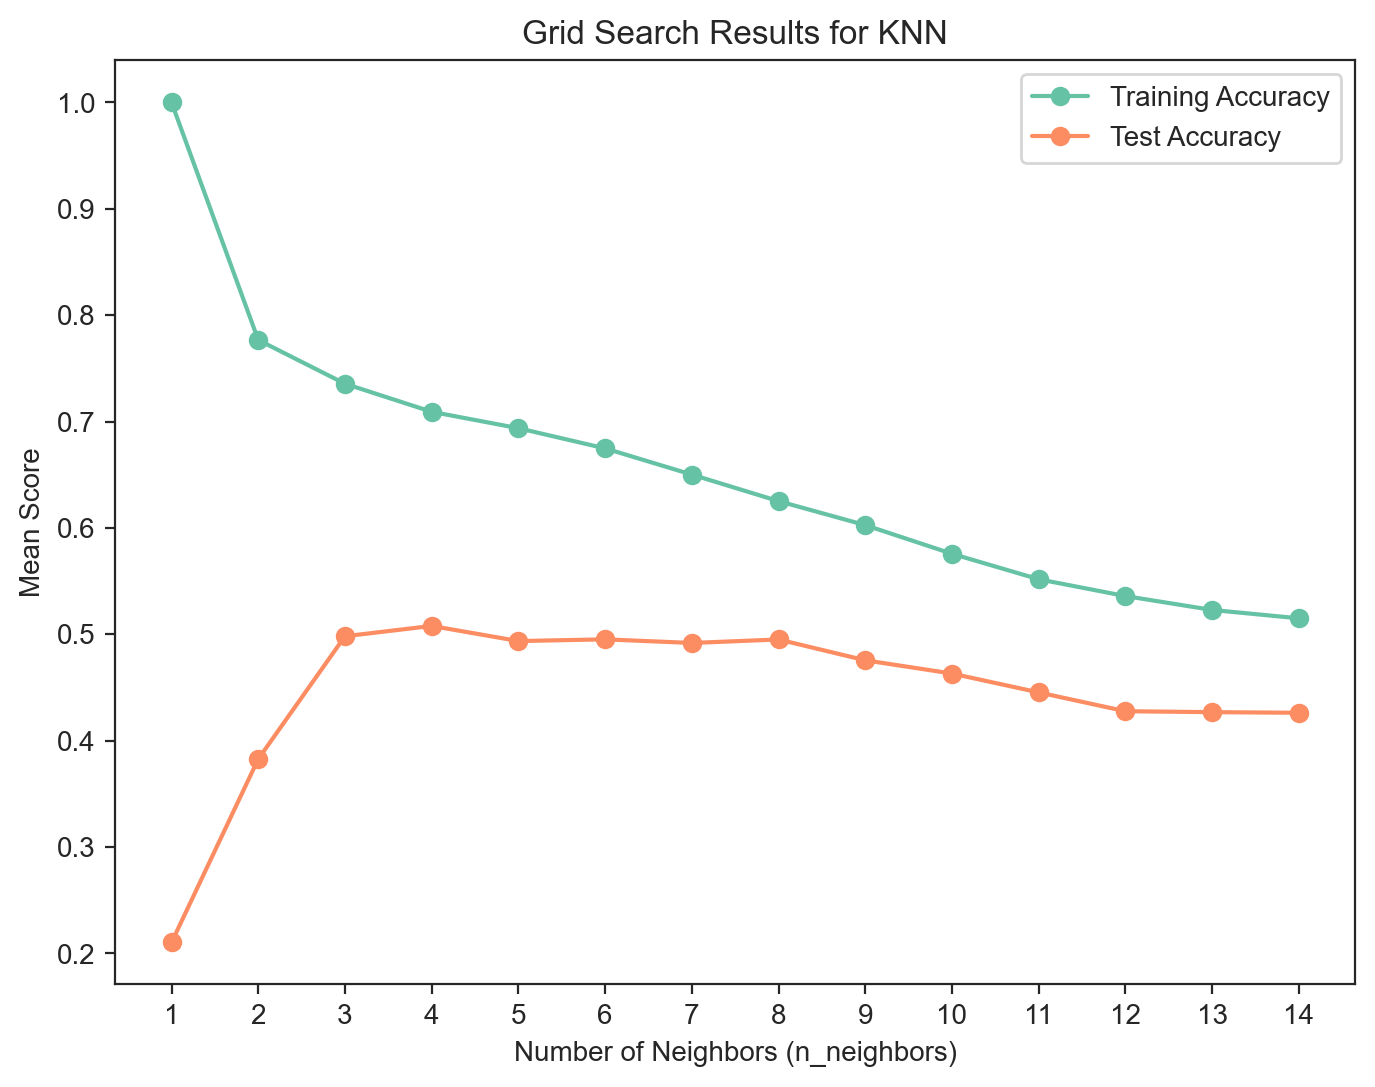

In [40]:
# Retrieve 'param_n_neighbors' and 'mean_test_score' from the grid search results DataFrame
param_values = gs_df['param_knn__n_neighbors'].astype(int)  # Convert to integer if not already
mean_train_scores = gs_df['mean_train_score'].astype(float)  # Convert to float if not already
mean_test_scores = gs_df['mean_test_score'].astype(float)  # Convert to float if not already

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot both training and test accuracy values
plt.plot(param_values, mean_train_scores, label='Training Accuracy', marker='o')
plt.plot(param_values, mean_test_scores, label='Test Accuracy', marker='o')

# Label the x-axis and y-axis
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Score')

# Set x-axis ticks to the 'n_neighbors' values
plt.xticks(param_values)

# Show plot title and display the plot
plt.title('Grid Search Results for KNN')
plt.legend()
# plt.savefig("/Users/hal/Documents/Essays/AutoML/knn_grid_search.png", bbox_inches='tight', dpi=240)

## DTR Grid Search

In [41]:
# Define the parameter grid
param_grid = {
    'dtr__max_depth': [20, 25, 30, 35, 40, 45, 50, 55, 60, None],
    'dtr__min_samples_split': [4, 8, 12, 16, 20, 24, 28, 32],
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(dtr_pipeline, param_grid, cv=5, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [42]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_dtr__max_depth', 'param_dtr__min_samples_split', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head(7)

,param_dtr__max_depth,param_dtr__min_samples_split,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
23,30,32,0.796995,0.014109,0.539956,0.072599,1
71,60,32,0.796995,0.014109,0.539956,0.072599,2
39,40,32,0.796995,0.014109,0.538300,0.077805,3
28,35,20,0.847434,0.022023,0.536703,0.108950,4
15,25,32,0.796995,0.014109,0.536249,0.078654,5
76,None,20,0.847434,0.022023,0.536143,0.104656,6
27,35,16,0.886602,0.017421,0.534845,0.118751,7


In [43]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

{'dtr__max_depth': 30, 'dtr__min_samples_split': 32}

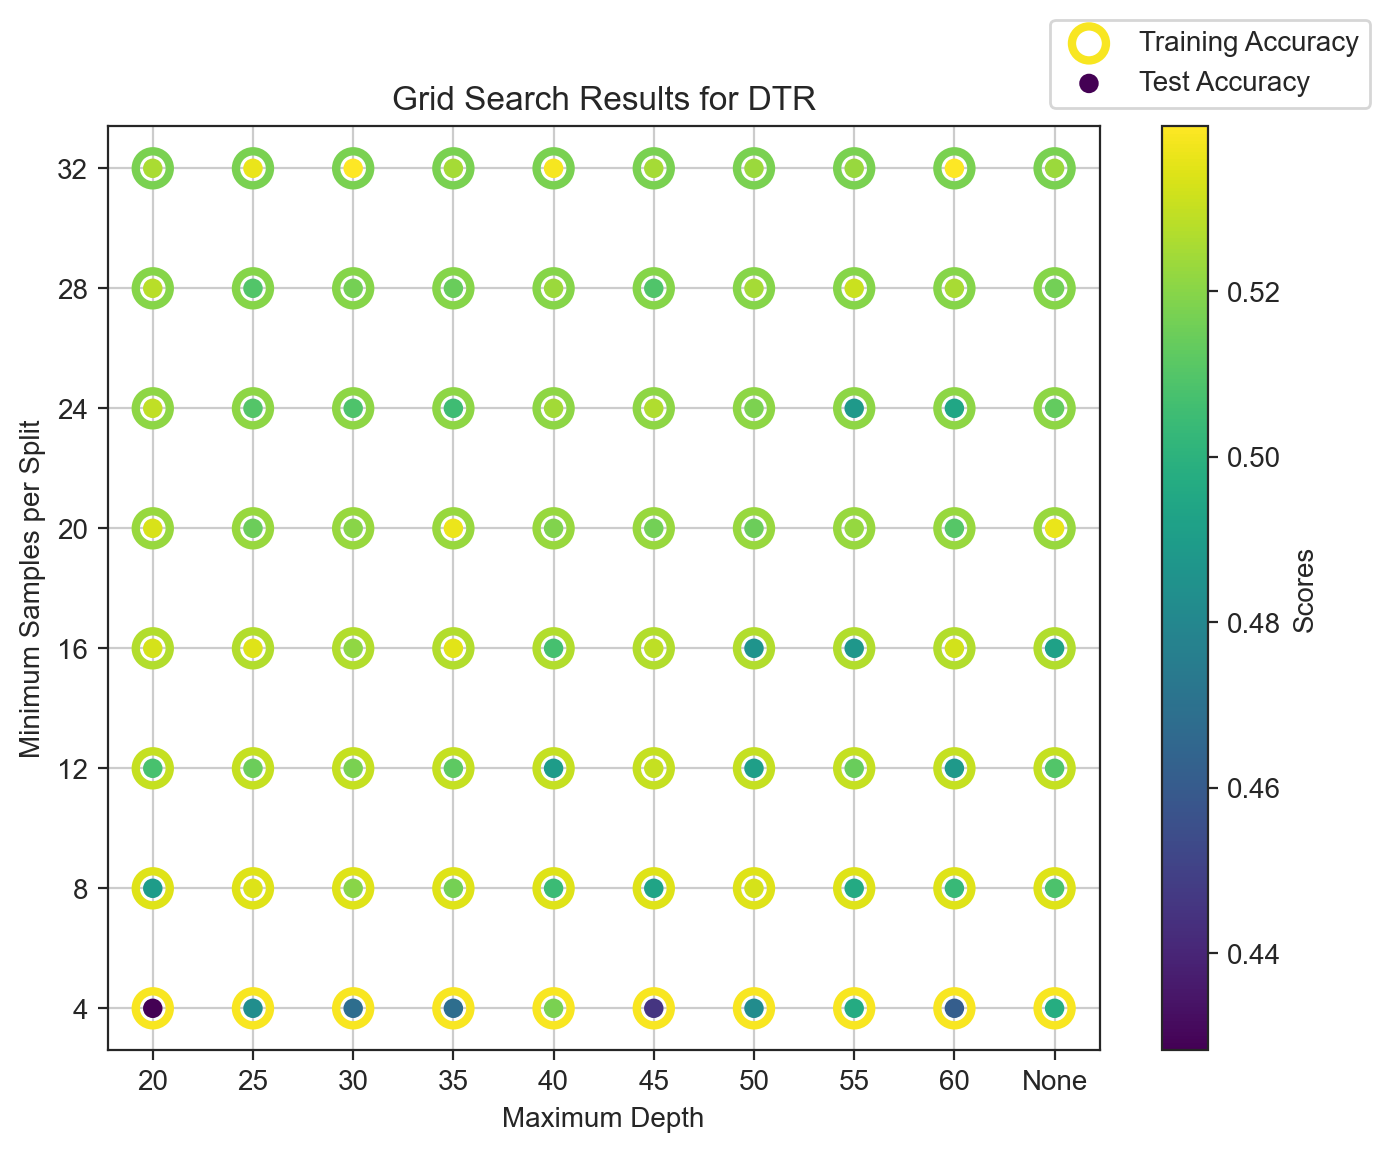

In [44]:
param_depth = gs_df['param_dtr__max_depth'] 
param_depth = param_depth.replace({None: 65})
param_split = gs_df['param_dtr__min_samples_split'] 

mean_train_scores = gs_df['mean_train_score'].astype(float)
mean_test_scores = gs_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

plt.scatter(
    param_depth, 
    param_split, 
    edgecolors=plt.cm.viridis(mean_train_scores),  # Color for edges
    facecolors='none',  # No fill
    s=150,  # Marker size
    linewidths=3,
    label='Training Accuracy'
)

scatter2 = plt.scatter(param_depth, param_split, c=mean_test_scores, cmap='viridis', marker="o", label='Test Accuracy')

# Label the x-axis and y-axis
plt.xlabel('Maximum Depth')
plt.ylabel('Minimum Samples per Split')

# Show plot title and display the plot
plt.title('Grid Search Results for DTR')
plt.legend(loc=(0.95, 1.02))
plt.xticks([20, 25, 30, 35, 40, 45, 50, 55, 60, 65], [20, 25, 30, 35, 40, 45, 50, 55, 60, "None"])
plt.yticks([4, 8, 12, 16, 20, 24, 28, 32])
plt.grid(True)
cbar = plt.colorbar(scatter2, cmap="viridis")
cbar.set_label('Scores')
plt.savefig("/Users/hal/Documents/Essays/AutoML/dtr_grid_search4.png", bbox_inches='tight', dpi=240)

In [45]:
%%capture
from matplotlib.animation import FuncAnimation

# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(param_depth, param_split, mean_test_scores, c=mean_test_scores, cmap='viridis')
ax.set_xlabel('Max depth')
ax.set_ylabel('Min Samples Split')
ax.set_zlabel('Score')
plt.title('3D Scatter Plot')

# Function to update the view angle for each frame
def update(frame):
    ax.view_init(elev=30, azim=frame/2)  # Rotate the view
    return ax,

# Create the animation
frames = list(range(180)) + list(range(180, 0, -1))
ani = FuncAnimation(fig, update, frames=frames, interval=20, blit=False);

# Save as MP4
ani.save("3d_scatter_rotation.mp4", writer="ffmpeg", fps=30);

<video src="3d_scatter_rotation.mp4" alt="3d_scatter_rotation" width="700" controls loop />

# Analysis

## Predictions

In [46]:
knn_pipeline.set_params(knn__n_neighbors=5)
knn_pipeline.fit(X_train, y_train)
actual = y_test.to_numpy().ravel()
knn_predicted = knn_pipeline.predict(X_test).ravel()

prediction_df = pd.DataFrame({'Actual': actual, 'KNN_Predicted': knn_predicted})

knn_pipeline.score(X_test, y_test)

0.4004510047223938

In [47]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
dtr_pipeline.fit(X_train, y_train)
dtr_predicted = dtr_pipeline.predict(X_test).ravel()

prediction_df["DTR_Predicted"] = dtr_predicted

dtr_pipeline.score(X_test, y_test)

0.39934800059431974

In [48]:
dtr = dtr_pipeline.named_steps["dtr"]
dtr.get_depth()

21

In [49]:
lnr_pipeline.fit(X_train, y_train)
lnr_predicted = lnr_pipeline.predict(X_test).ravel()

prediction_df["LNR_Predicted"] = lnr_predicted

lnr_pipeline.score(X_test, y_test)

0.6970168549870379

In [50]:
# Un-transform the price
prediction_scaled = prediction_df.copy()
prediction_scaled["Actual"]        = np.e**prediction_df["Actual"]
prediction_scaled["KNN_Predicted"] = np.e**prediction_df["KNN_Predicted"]
prediction_scaled["DTR_Predicted"] = np.e**prediction_df["DTR_Predicted"]
prediction_scaled["LNR_Predicted"] = np.e**prediction_df["LNR_Predicted"]

# Scale price to 1000s of pounds for readability
prediction_scaled["Actual"]        = prediction_scaled["Actual"]/1000
prediction_scaled["KNN_Predicted"] = prediction_scaled["KNN_Predicted"]/1000
prediction_scaled["DTR_Predicted"] = prediction_scaled["DTR_Predicted"]/1000
prediction_scaled["LNR_Predicted"] = prediction_scaled["LNR_Predicted"]/1000

In [51]:
# Find the linear model's worst predictions

dif = prediction_scaled["Actual"] - prediction_scaled["LNR_Predicted"]
worst_predictions = dif.sort_values()
worst_predictions
X_cars_pred = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
worst_pred_cars = X_cars_pred.loc[worst_predictions.index]

worst_pred_cars["Off_by"] = worst_predictions
worst_pred_cars["Off_by"] = worst_pred_cars["Off_by"].round(3)
worst_pred_cars.to_csv("lnr_worst.csv")
worst_pred_cars

worst_pred_cars = worst_pred_cars.dropna()
worst_pred_cars["year_of_registration"] = worst_pred_cars["year_of_registration"].astype(int)
worst_pred_cars["name"] = worst_pred_cars["year_of_registration"].astype(str) + " " +  worst_pred_cars["standard_make"] + " " + worst_pred_cars["standard_model"]
worst_pred_cars["price"] = prediction_scaled.loc[worst_predictions.index, "Actual"]*1000
worst_pred_cars["off by percent"] = worst_pred_cars["Off_by"]/ worst_pred_cars["price"]
worst_pred_cars["off by percent"] = worst_pred_cars["off by percent"] * 100
worst_pred_cars[["name", "Off_by", "off by percent"]].sort_values(by="off by percent").head(10).to_csv("lnr_worst.csv")

## Plot a sample of predictions

In [52]:
plot_sample_size = 10

df_plot = prediction_scaled.sample(plot_sample_size, random_state=seed)

X_cars = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
X_cars_sample = X_cars.loc[df_plot.index]
X_cars_sample["year_of_registration"] = X_cars_sample["year_of_registration"].astype(int)
X_cars_sample["name"] = X_cars_sample["year_of_registration"].astype(str) + " " +  X_cars_sample["standard_make"] + " " + X_cars_sample["standard_model"]

In [53]:
df_with_names = df_plot.copy()
df_with_names["Name"] = X_cars_sample["name"]
df_with_names["KNN_Predicted"] = df_with_names["KNN_Predicted"].round(3)
df_with_names["DTR_Predicted"] = df_with_names["DTR_Predicted"].round(3)
df_with_names["LNR_Predicted"] = df_with_names["LNR_Predicted"].round(3)
df_with_names.to_csv("predictions.csv")

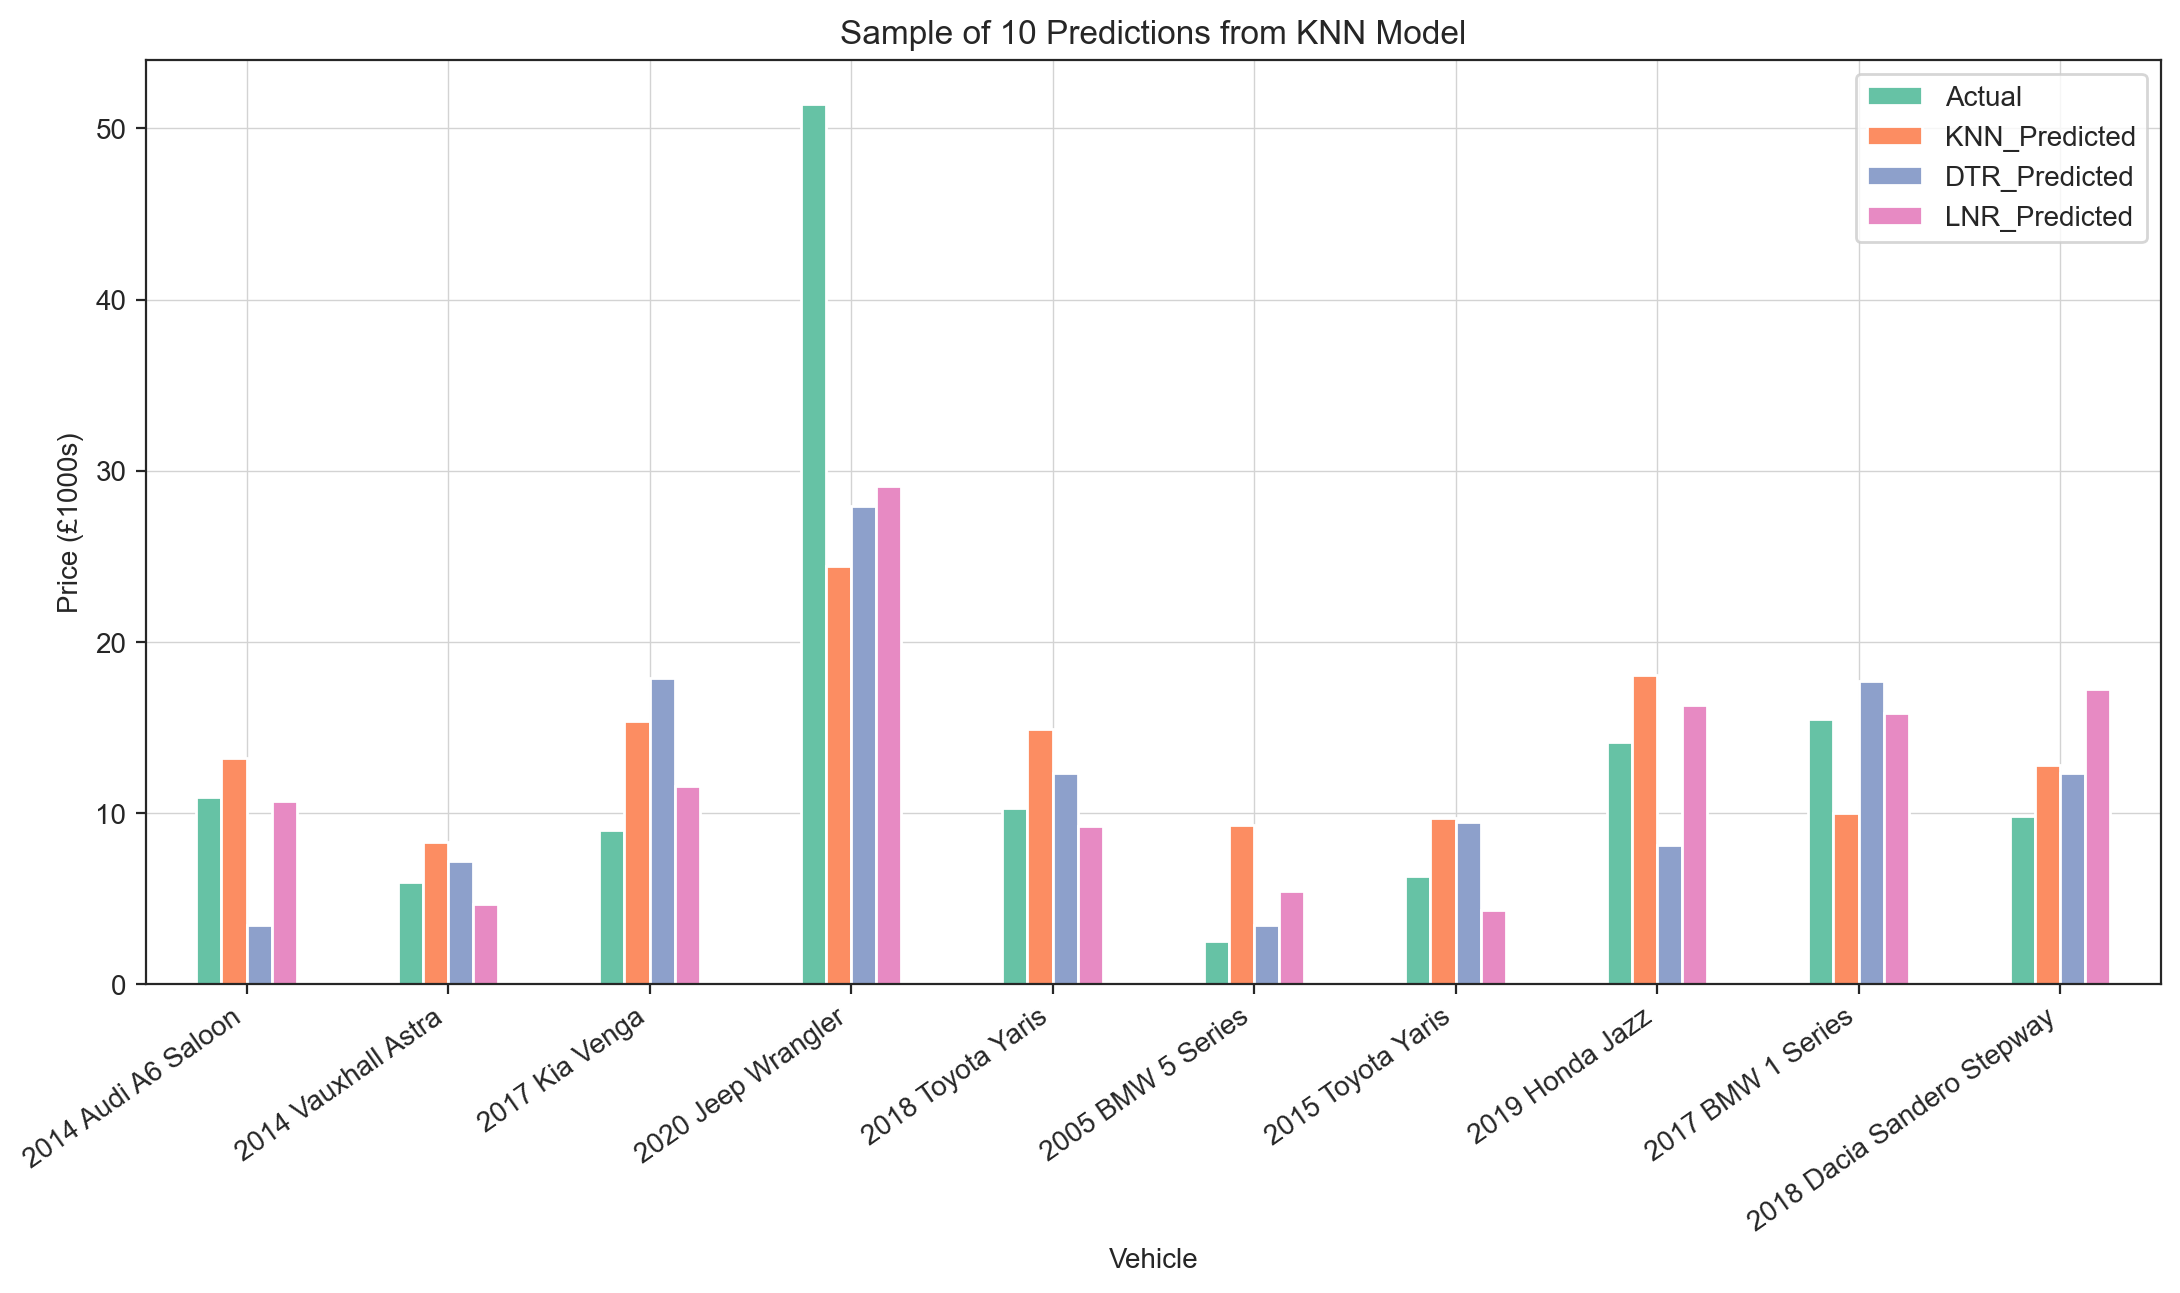

In [54]:
df_plot.plot(kind='bar',figsize=(13,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgray')
plt.xticks(ticks=np.arange(0, plot_sample_size), labels=X_cars_sample["name"], rotation=35, ha="right")
plt.title("Sample of 10 Predictions from KNN Model")
plt.ylabel("Price (£1000s)")
plt.xlabel("Vehicle");
plt.savefig("/Users/hal/Documents/Essays/AutoML/mixed_results_sample2.png", bbox_inches='tight', dpi=200)

## Residuals

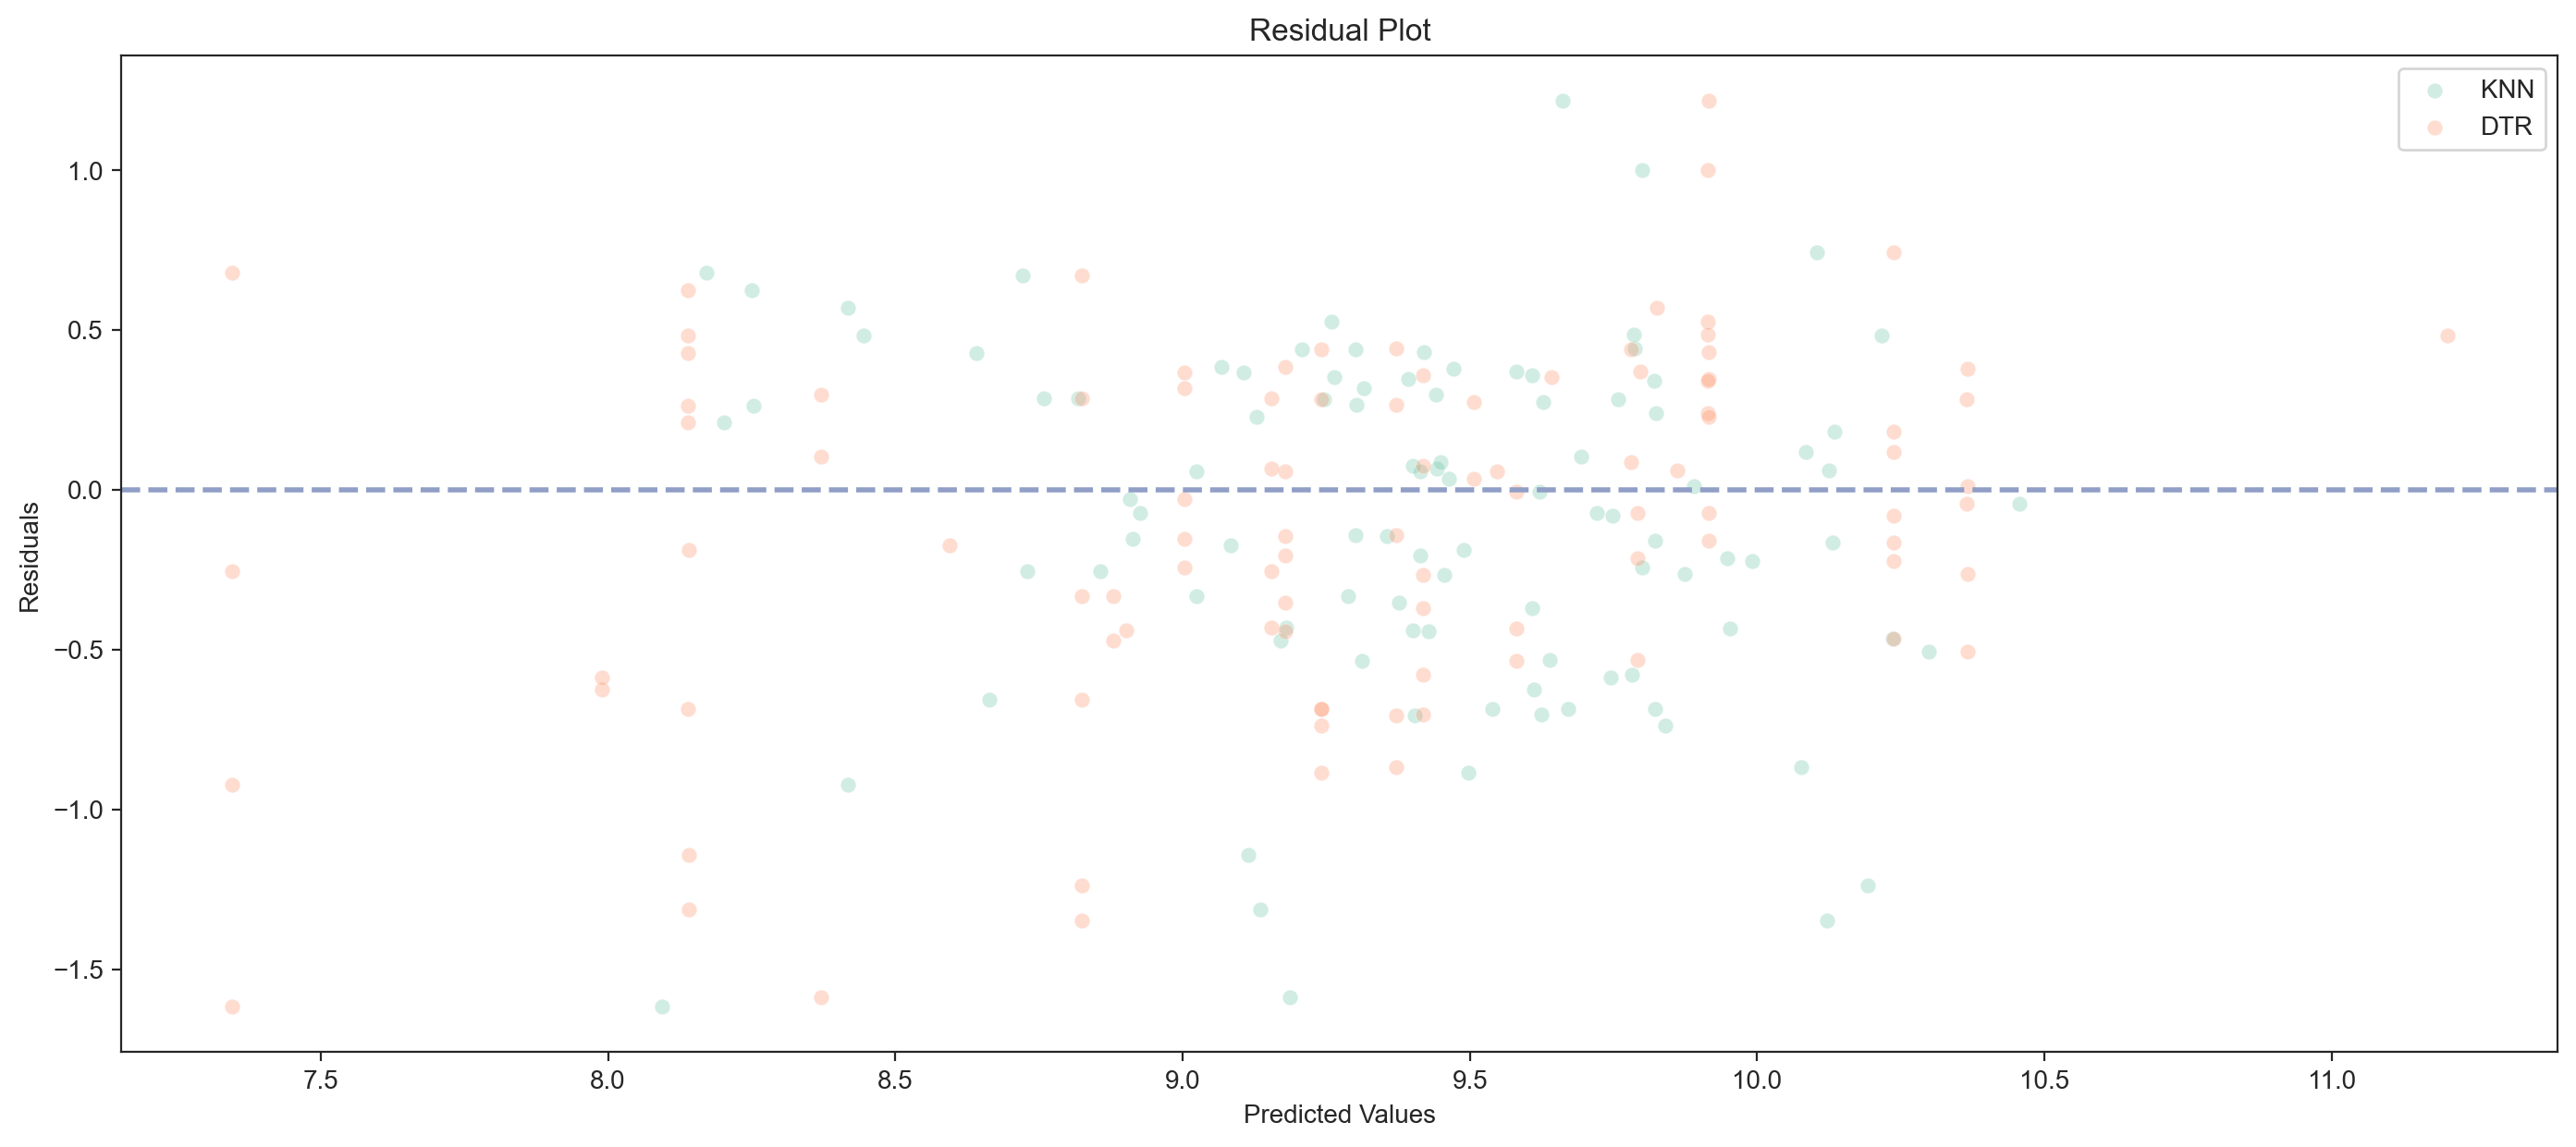

In [55]:
knn_residuals = prediction_df["Actual"] - prediction_df["KNN_Predicted"]
dtr_residuals = prediction_df["Actual"] - prediction_df["DTR_Predicted"]
lnr_residuals = prediction_df["Actual"] - prediction_df["LNR_Predicted"]

sns.scatterplot(x=prediction_df["KNN_Predicted"], y=knn_residuals, alpha=0.3, label="KNN")
sns.scatterplot(x=prediction_df["DTR_Predicted"], y=knn_residuals, alpha=0.3, label="DTR")
plt.axhline(0, color='#919FC7', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot");

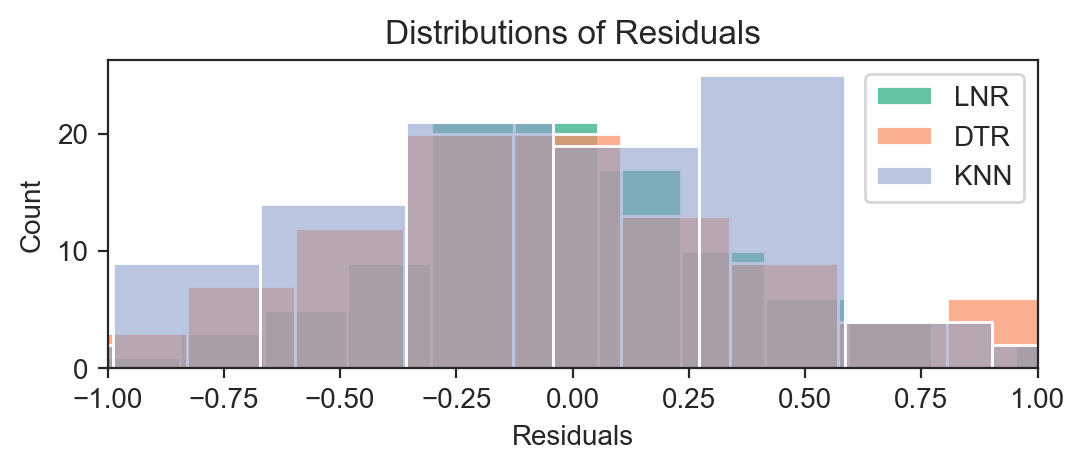

In [56]:
plt.figure(figsize=(6, 2))
sns.histplot(lnr_residuals, label="LNR", alpha=1)
sns.histplot(dtr_residuals, label="DTR", alpha=0.7)
sns.histplot(knn_residuals, label="KNN", alpha=0.6)
# plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.title("Distributions of Residuals")
plt.legend()
plt.xlabel("Residuals")
plt.savefig("/Users/hal/Documents/Essays/AutoML/residuals_dist.png", bbox_inches='tight', dpi=200)

In [58]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 49.9 kB/s eta 0:00:0000:0300:11


In [57]:
import plotly.express as px

y_pred = prediction_df["KNN_Predicted"]

fig = px.scatter(x=y_pred, y=knn_residuals, labels={'x': 'Predicted', 'y': 'Residuals'})
fig = px.scatter(x=y_pred, y=dtr_residuals, labels={'x': 'Predicted', 'y': 'Residuals'})
fig.add_shape(type='line', x0=y_pred.min(), y0=0, x1=y_pred.max(), y1=0,
              line=dict(color='Red', dash='dash'))
fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

ModuleNotFoundError: No module named 'plotly'

## Tree Vis

In [ ]:
# Load the dataset
auto = pd.read_csv("adverts.csv")
auto = auto.sample(50000, random_state=seed)
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Load the dataset
auto = pd.read_csv("adverts.csv")
auto = auto.sample(50000, random_state=seed)

X = auto.drop('price', axis=1)
y = auto["price"]
y = np.log(y)

preprocessor.set_params(pre__cat__ohenc__max_categories=5)
X = preprocessor.fit_transform(X)
y = y.loc[X.index]

y = y.reset_index(drop=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
import dtreeviz
import cairosvg

dtr = DecisionTreeRegressor(max_depth=4)

# Fit the tree
dtr.fit(X_train, y_train)
print(dtr.score(X_test, y_test))

# Create dtreeviz model
vis = dtreeviz.model(
    dtr,
    X_test,
    y_test,
    feature_names=preprocessor.get_feature_names_out(),
    target_name='log_price')

v = vis.view(fontname='sans-serif', scale=2)
v.save("tree.svg") 

cairosvg.svg2png(url="tree.svg", write_to="tree.png") # Adjust scale as needed

0.6414689466453777


## Linear Model

In [ ]:
X = preprocessor.fit_transform(X)
y = auto["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# R2 by default amount of variance of the target explained by the model
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9065907335014188, 0.8988784716459843)

<Figure size 800x800 with 0 Axes>

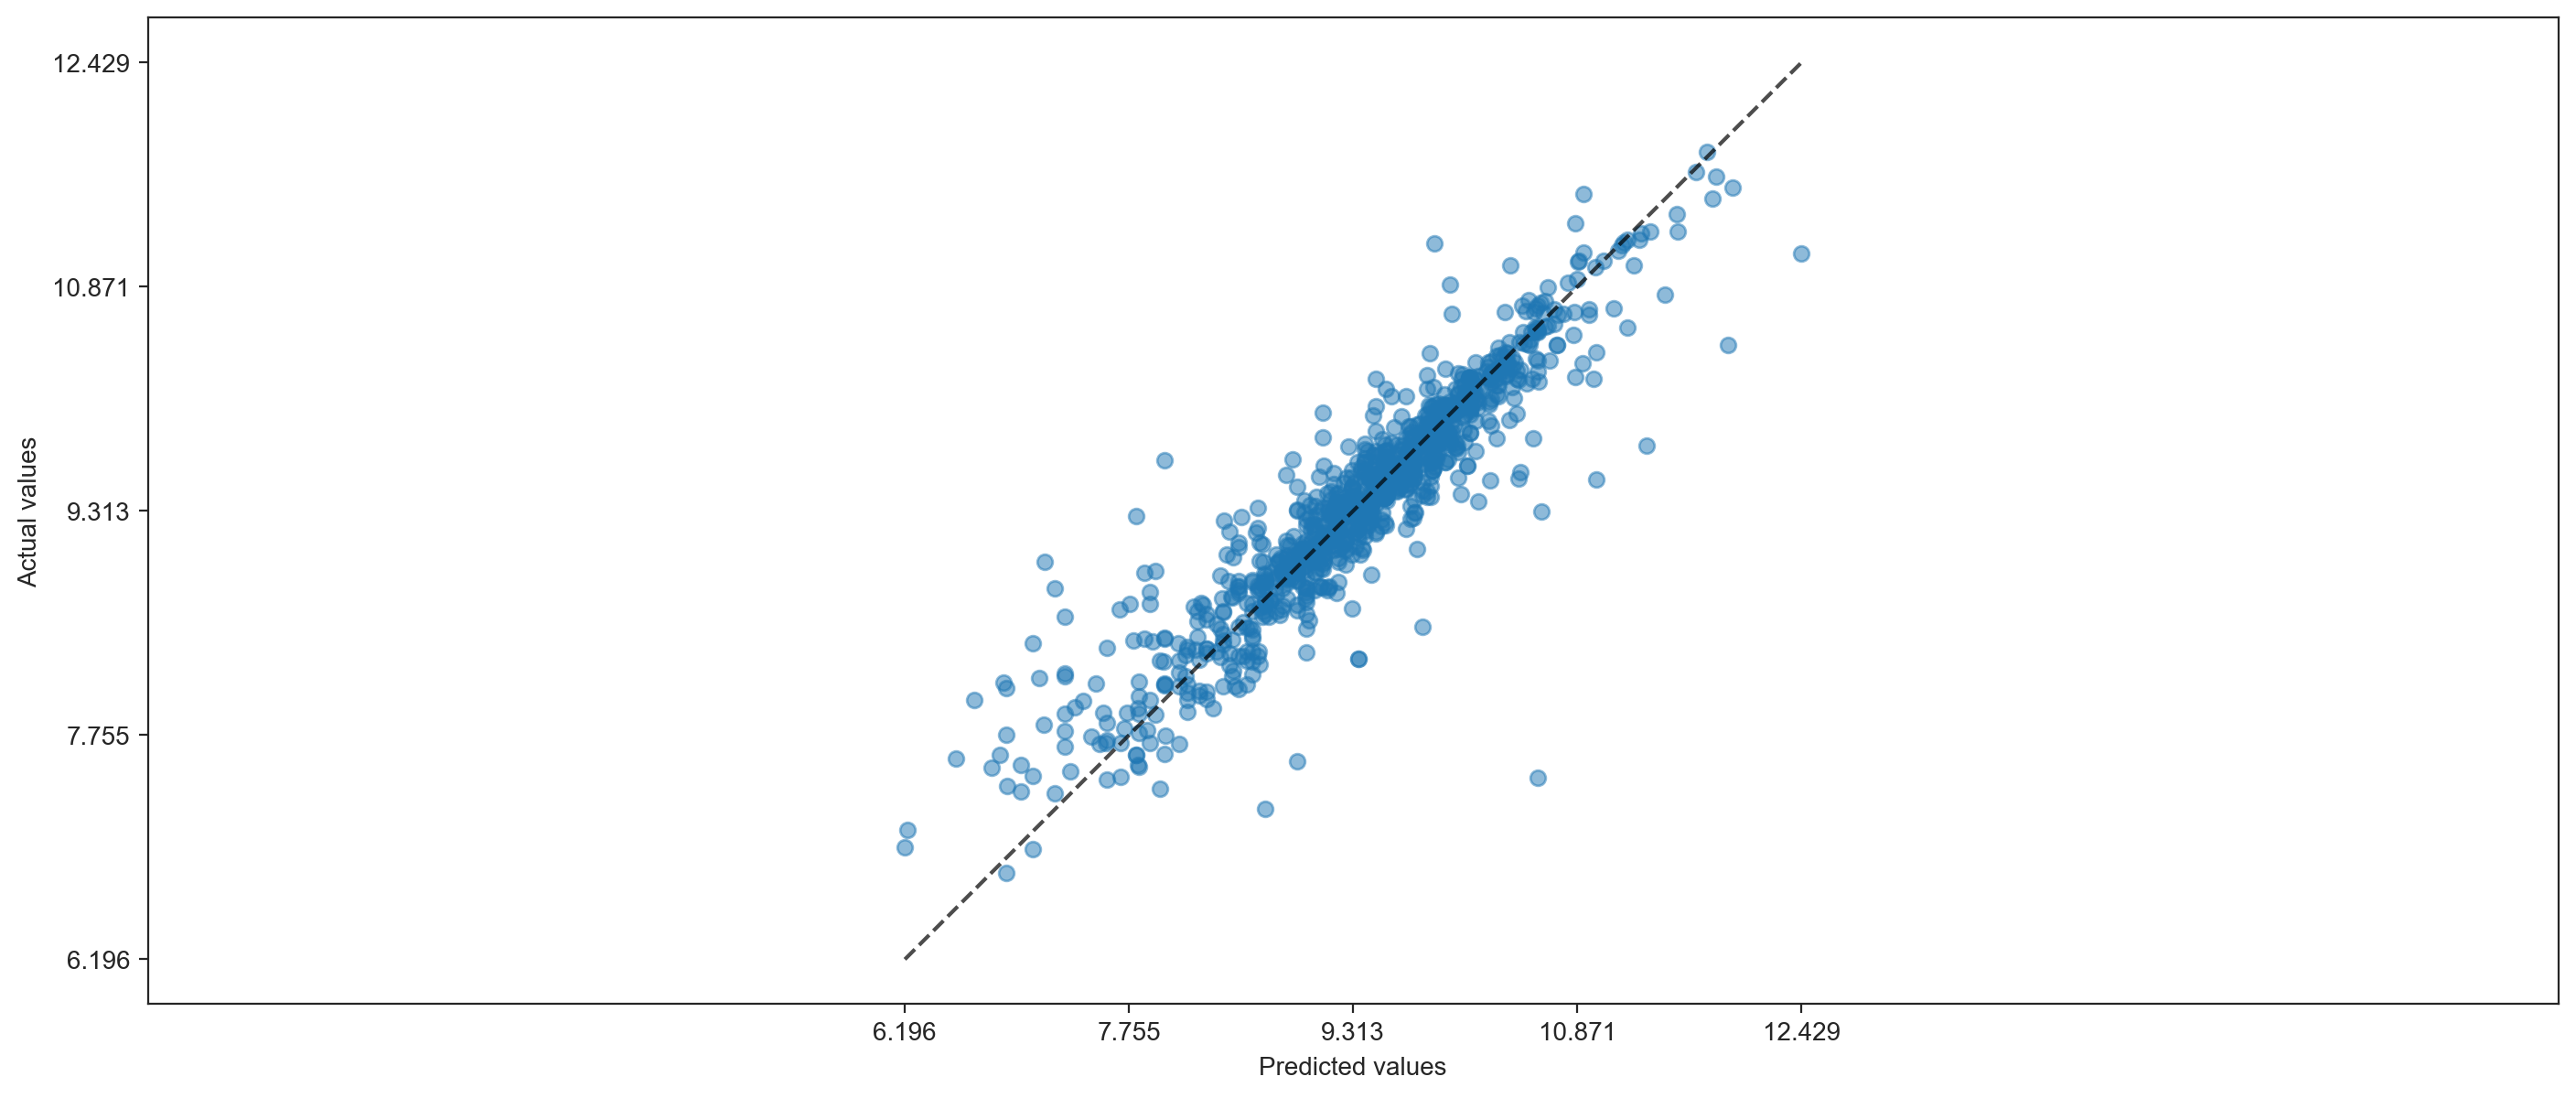

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

plt.figure(figsize=(8, 8))
PredictionErrorDisplay.from_predictions(
    prediction_df["KNN_Predicted"], prediction_df["Actual"],
    kind="actual_vs_predicted",
    scatter_kwargs=dict(alpha=0.5),
)

In [ ]:
# Fits the explainer
explainer = shap.Explainer(lr.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

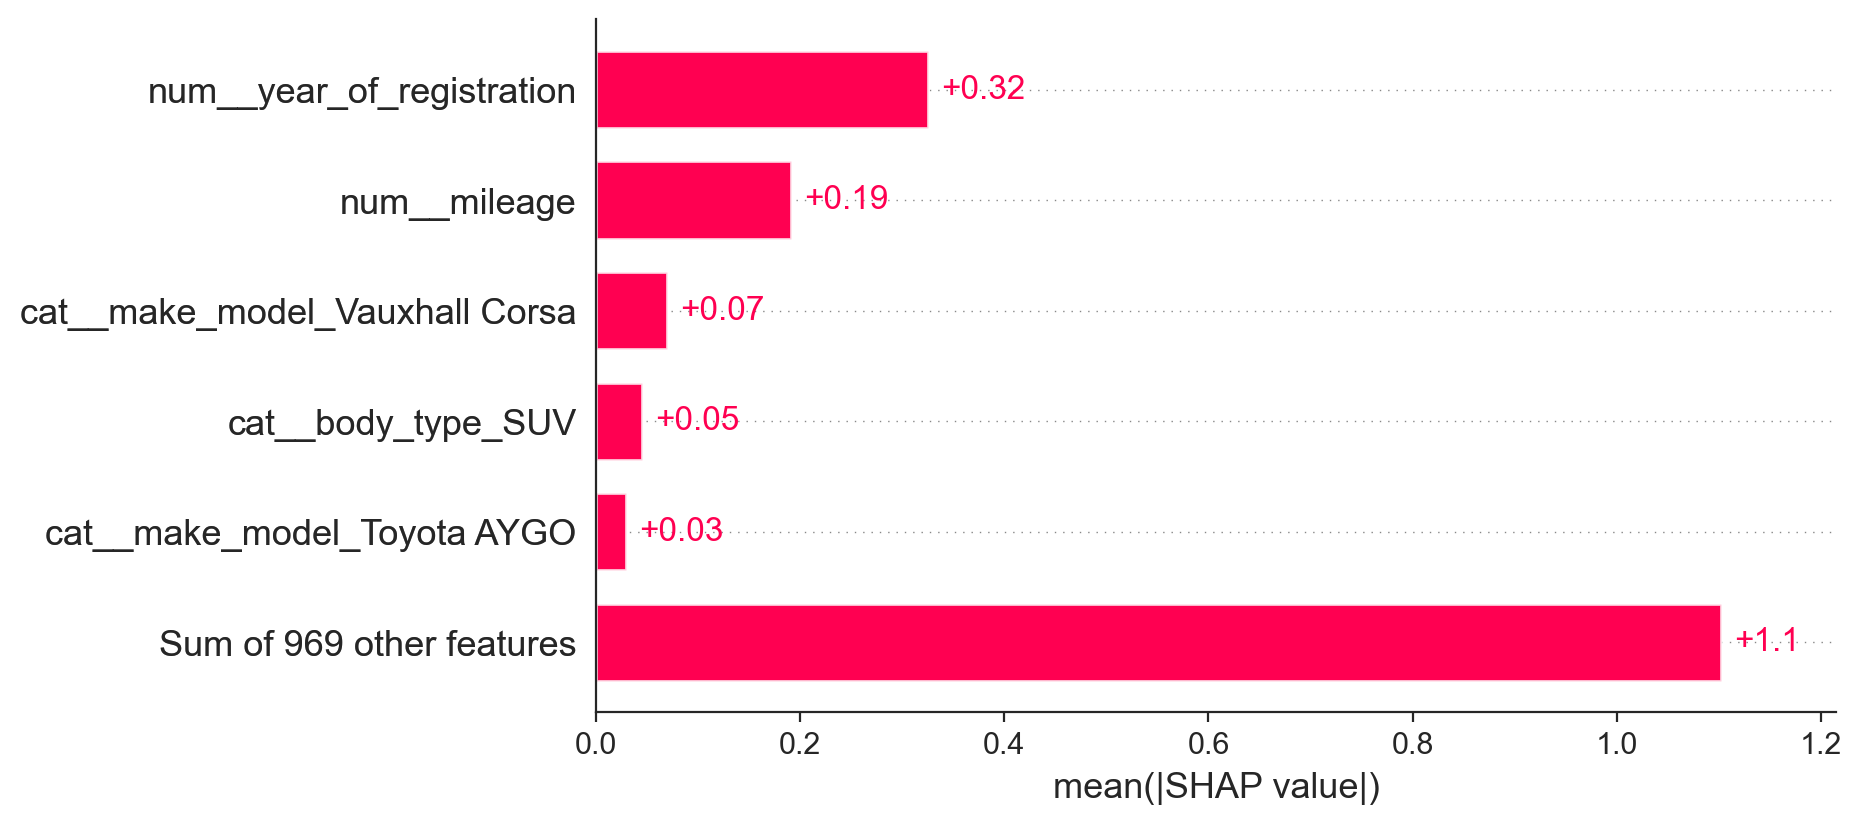

In [ ]:
shap.plots.bar(shap_values, max_display=6)

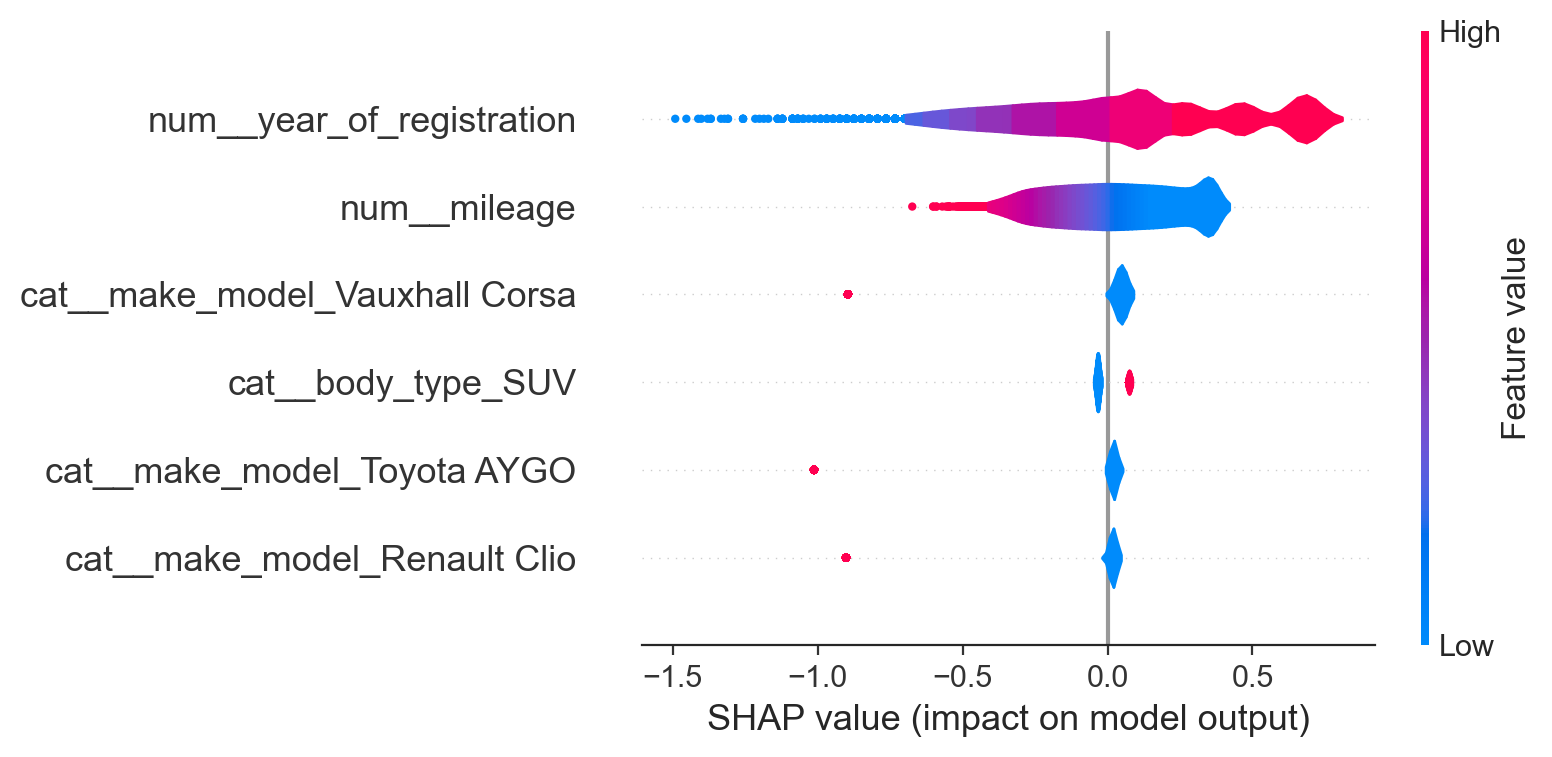

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=6)

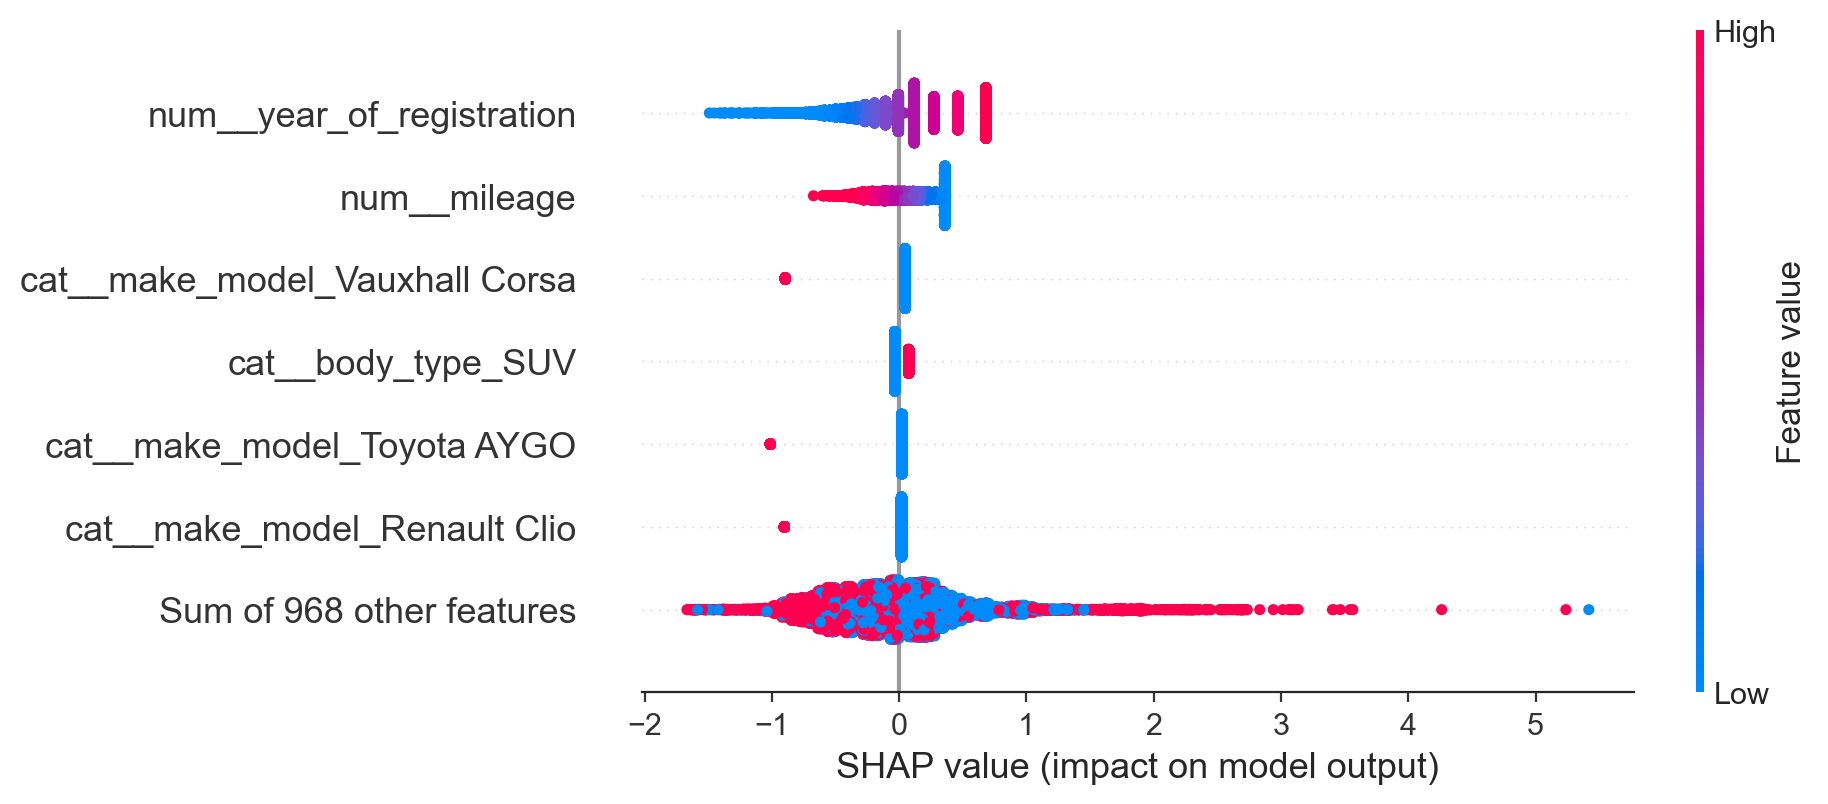

In [ ]:
shap.plots.beeswarm(shap_values, max_display=7)

In [ ]:
auto.loc[(auto["price"]==y_test.iloc[5]) & (auto["standard_model"]=="Yaris")]

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
301889,202009304408142,16092.0,17,Grey,Toyota,Yaris,USED,2017.0,9.08137,Hatchback,False,Petrol


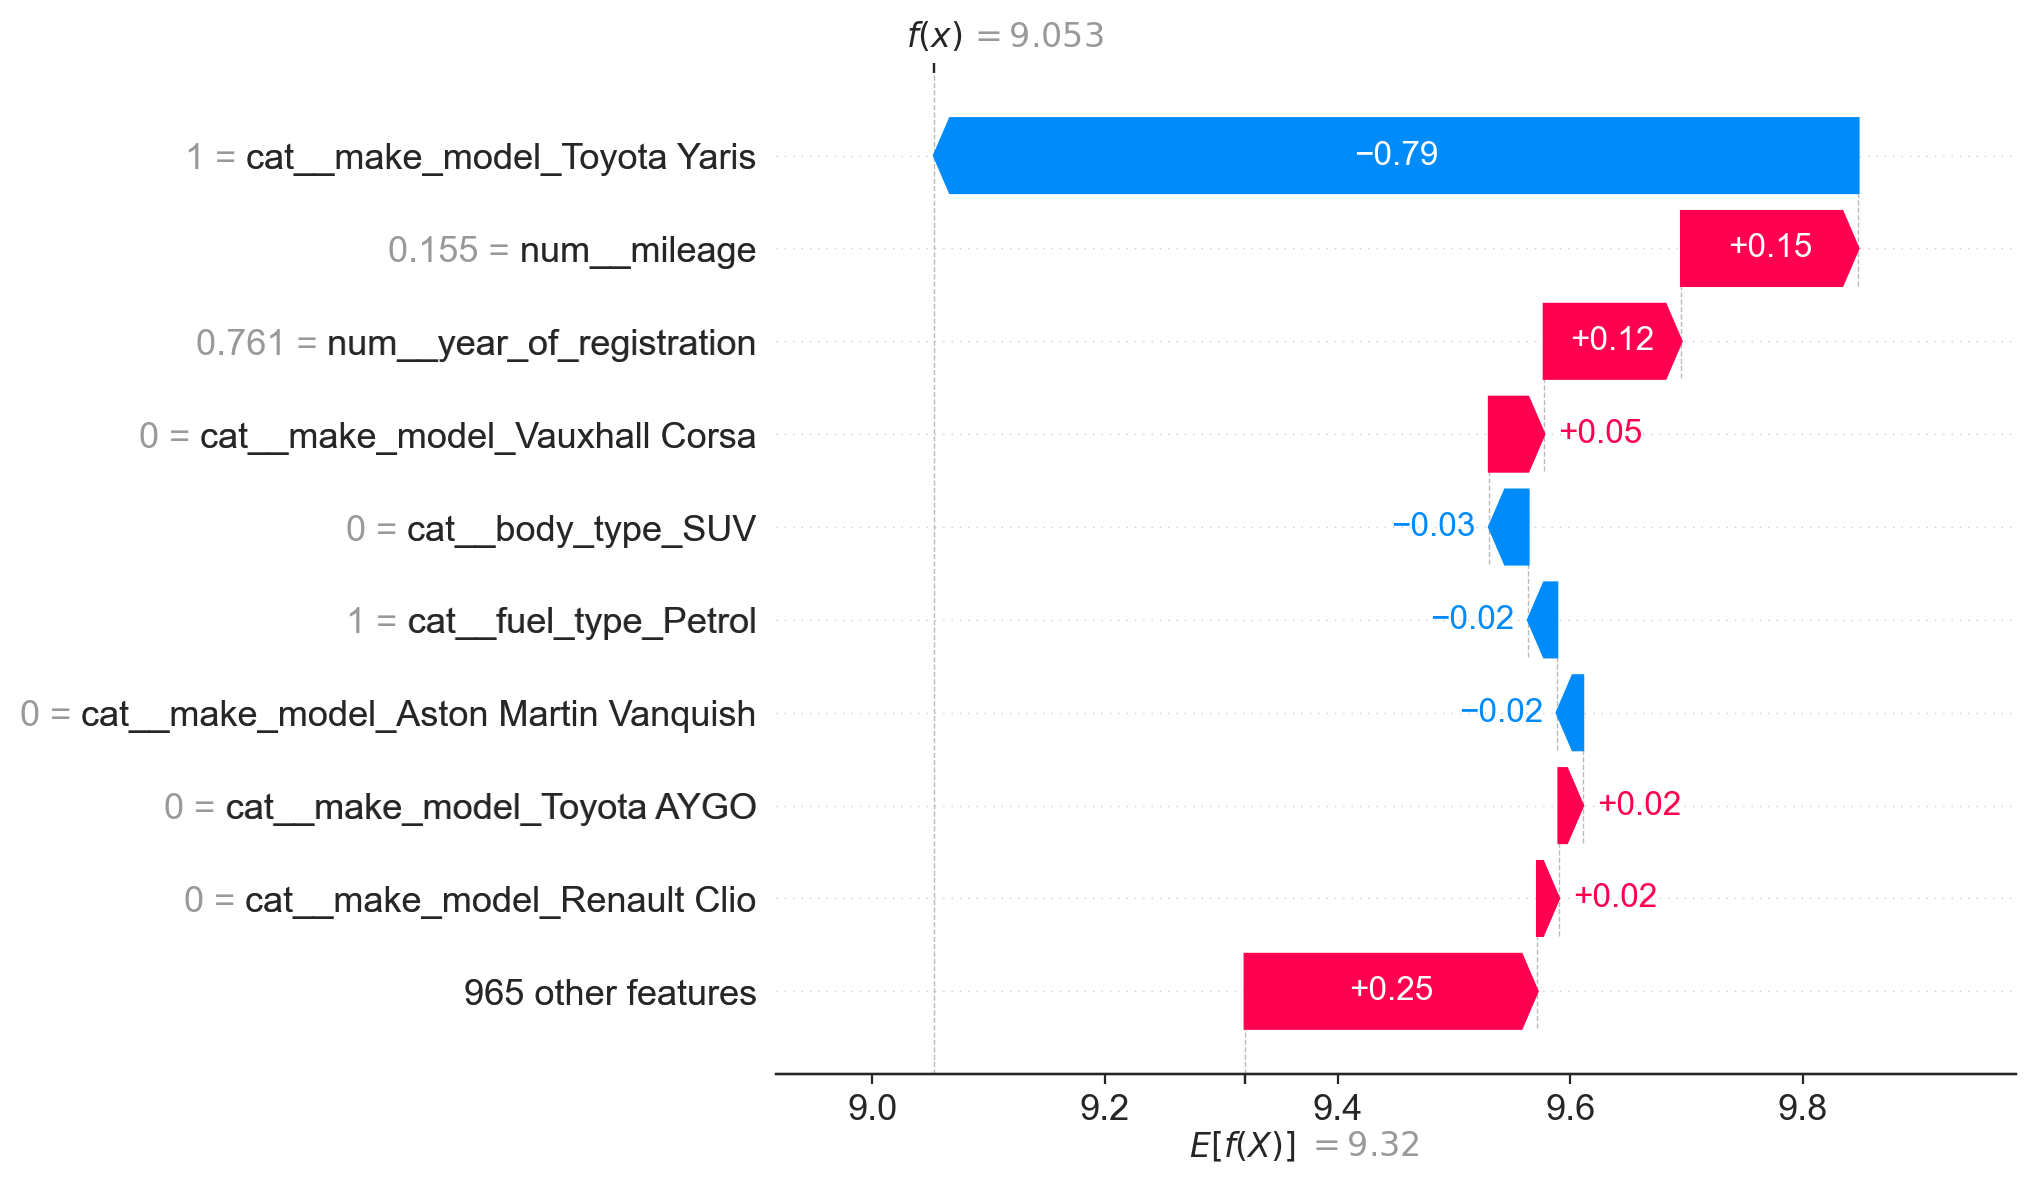

In [ ]:
shap.plots.waterfall(shap_values[5])
# 2017 Used Grey Toyota Yaris, Petrol, 16092.0 miles 

## KNN

In [ ]:
from yellowbrick.regressor import ResidualsPlot

auto_sample = auto.sample(50000, random_state=seed)

X, y = auto_sample.drop(columns=["price"]), auto_sample["price"]

X = preprocessor.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1)

0.3216948765661176

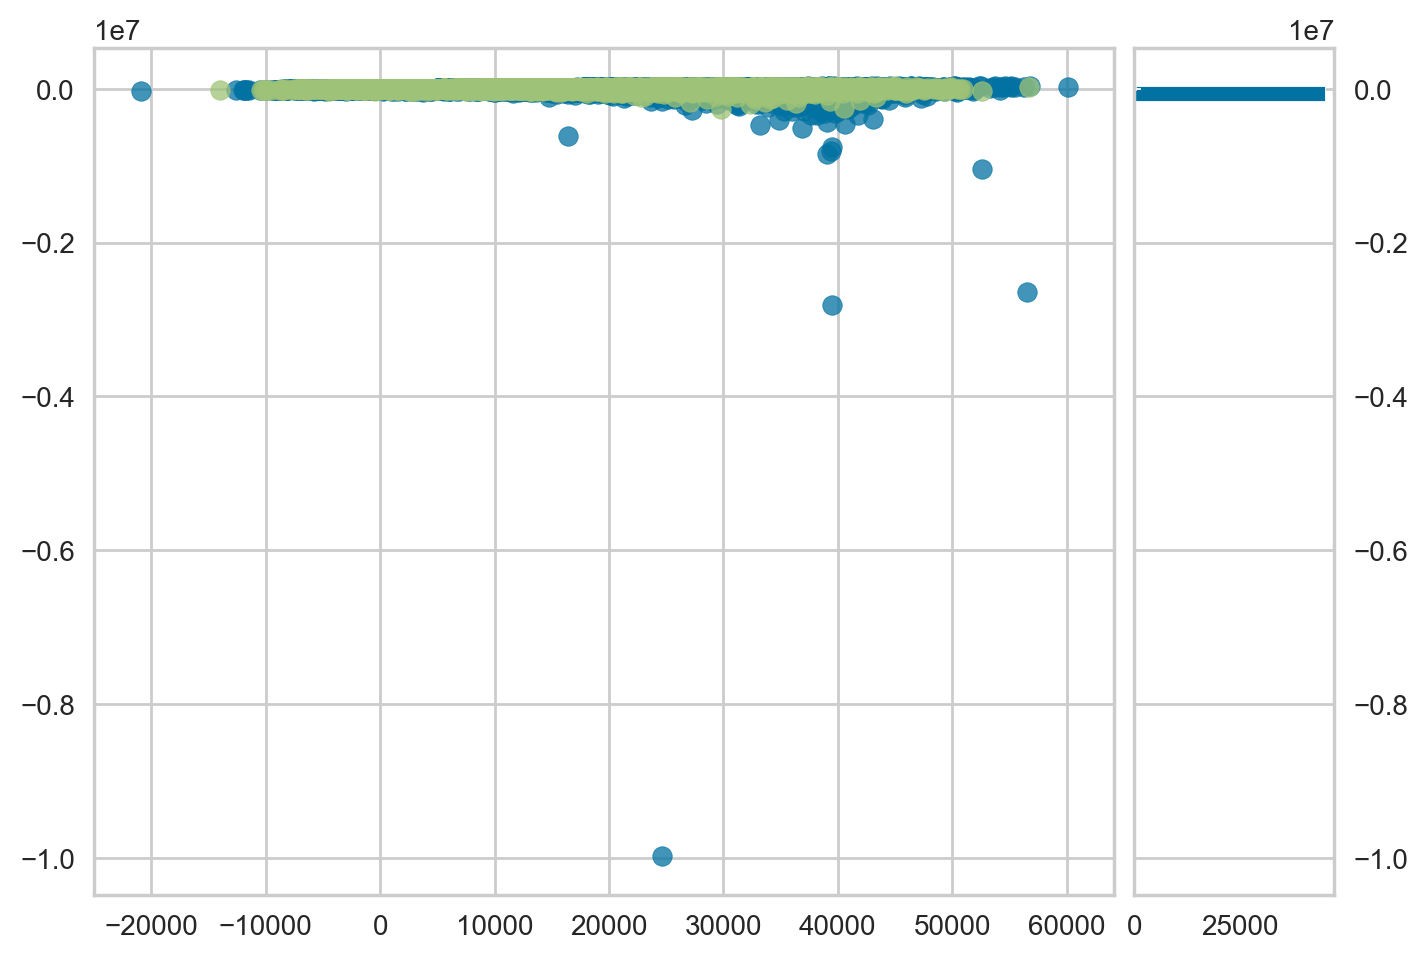

In [ ]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

0.33213915669959415

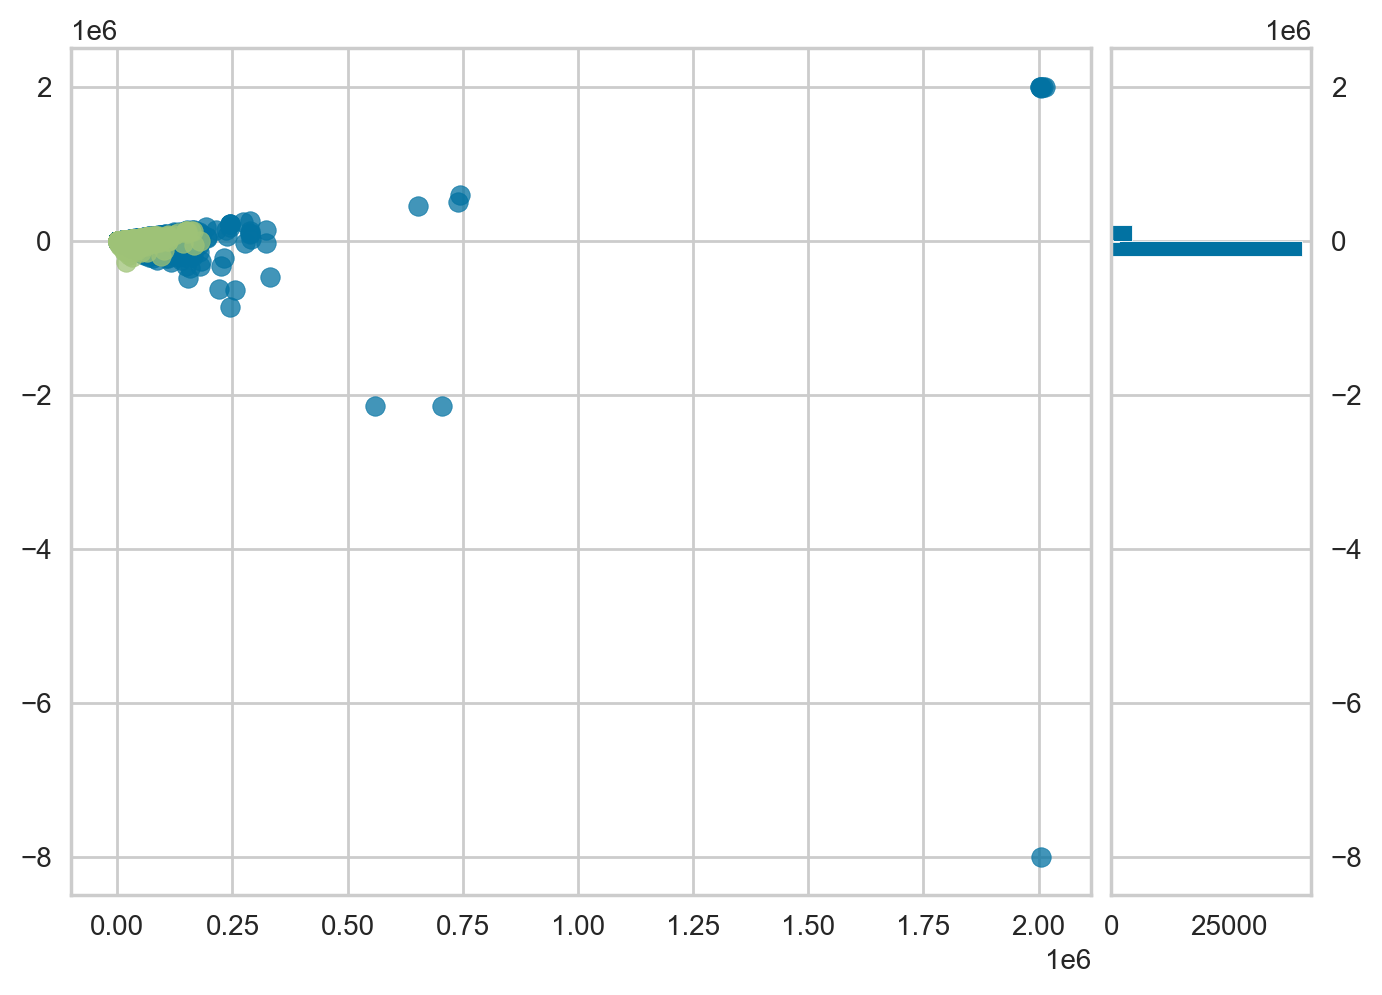

In [ ]:
visualizer = ResidualsPlot(KNeighborsRegressor())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

-0.018725072271907228

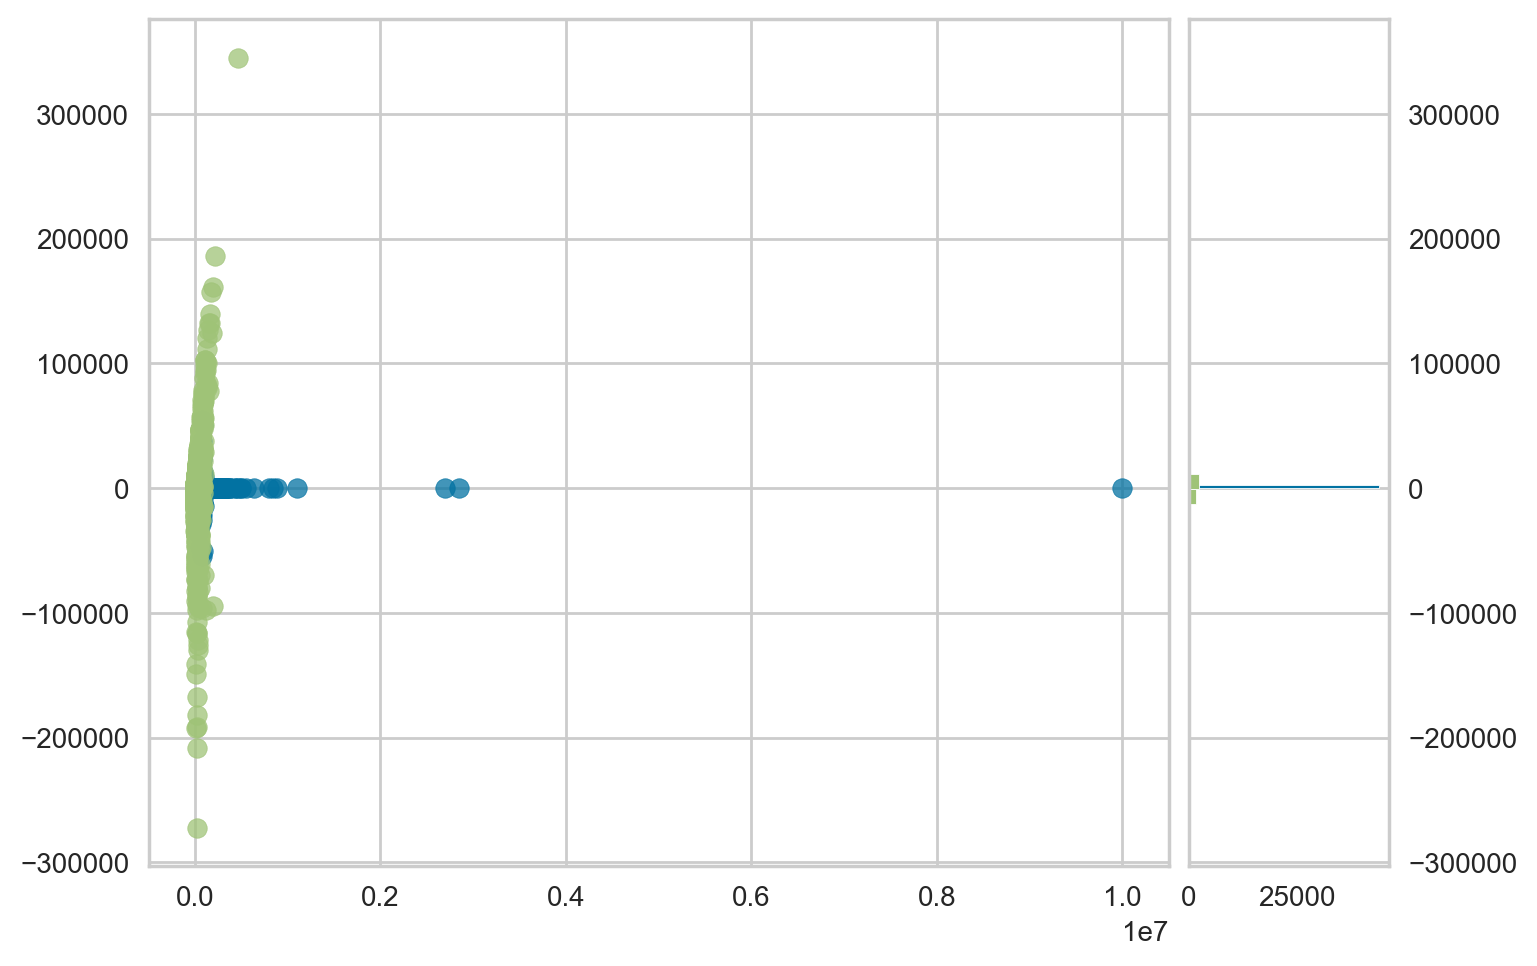

In [ ]:
visualizer = ResidualsPlot(DecisionTreeRegressor(splitter="best", max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

In [ ]:
X_train_summary = shap.kmeans(X_train, 10)
ex = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0, :])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0, :])

In [ ]:
shap.force_plot(ex.expected_value, shap_values, X_test)